# TFM Card Data

In [1]:
%load_ext dotenv
%dotenv

import pandas as pd
import numpy as np
import os
import json
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
from pathlib import Path

# Configure matplotlib to support Chinese characters using custom font
font_path = './fonts/MapleMono-NF-CN-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [prop.get_name()]
plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
# 加载中文名称映射
CN_MAP_FILE = './data/cn_merged.json'
import re

def load_cn_map(filepath):
    """加载中文名称映射"""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            cn_map = json.load(f)
        print(f"从 {filepath} 加载了 {len(cn_map)} 个中文名称映射")
        return cn_map
    except FileNotFoundError:
        print(f"警告: {filepath} 不存在")
        return {}

def strip_emoji(text):
    """移除 emoji 字符，用于 matplotlib 显示"""
    # Remove emoji and other special Unicode characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"  # dingbats
        u"\U0001F900-\U0001F9FF"  # supplemental symbols
        u"\U0001FA00-\U0001FA6F"  # chess symbols
        u"\U0001FA70-\U0001FAFF"  # symbols extended
        u"\U00002600-\U000026FF"  # misc symbols
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text).strip()

def get_cn_name(name, cn_map):
    """获取中文名称，如果没有则返回原名"""
    return cn_map.get(name, name)

def get_cn_name_for_plot(name, cn_map):
    """获取中文名称用于绘图（移除 emoji）"""
    cn_name = cn_map.get(name, name)
    return strip_emoji(cn_name)

def add_cn_name_column(df, name_column, cn_map):
    """为 DataFrame 添加 cn_name 列"""
    df = df.copy()
    df['cn_name'] = df[name_column].apply(lambda x: get_cn_name(x, cn_map))
    df['cn_name_plot'] = df[name_column].apply(lambda x: get_cn_name_for_plot(x, cn_map))
    return df

# 加载中文映射
CN_MAP = load_cn_map(CN_MAP_FILE)

# 测试
test_names = ['Tharsis Republic', 'EcoLine', 'Project Eden', 'Allied Bank', '🌸Weyland Yutani🌸']
print("测试中文名称映射:")
for name in test_names:
    cn = get_cn_name(name, CN_MAP)
    cn_plot = get_cn_name_for_plot(name, CN_MAP)
    print(f"  {name} -> {cn} (plot: {cn_plot})")

# 平均顺位：返回顺位用于聚合得到平均顺位（越低越好）
def calc_weighted_score(position, players):
    """返回顺位，agg 取 mean 即平均顺位。平均顺位越低越好。"""
    return float(position)


从 ./data/cn_merged.json 加载了 3406 个中文名称映射
测试中文名称映射:
  Tharsis Republic -> Tharsis Republic (plot: Tharsis Republic)
  EcoLine -> EcoLine (plot: EcoLine)
  Project Eden -> 伊甸园计划 (plot: 伊甸园计划)
  Allied Bank -> 联合银行 (plot: 联合银行)
  🌸Weyland Yutani🌸 -> 🌸韦兰德-尤坦尼集团🌸 (plot: 韦兰德-尤坦尼集团)


In [3]:
# 数据加载：优先从本地 SQLite，否则从远程 PostgreSQL (只读)
# 只加载 breakthrough=true 的游戏数据
LOCAL_DB_PATH = './local_data/tfm.db'

def load_data_from_local():
    """从本地 SQLite 加载数据"""
    if not Path(LOCAL_DB_PATH).exists():
        return None, None, None

    conn = sqlite3.connect(LOCAL_DB_PATH)
    games_df = pd.read_sql('SELECT * FROM games', conn)
    game_results_df = pd.read_sql('SELECT * FROM game_results', conn)
    user_game_results_df = pd.read_sql('SELECT * FROM user_game_results', conn)
    conn.close()

    # 过滤 breakthrough=true 的游戏
    if 'game_options' in game_results_df.columns:
        breakthrough_games = game_results_df[
            game_results_df['game_options'].str.contains('"breakthrough":true', na=False)
        ]['game_id'].tolist()
        game_results_df = game_results_df[game_results_df['game_id'].isin(breakthrough_games)]
        user_game_results_df = user_game_results_df[user_game_results_df['game_id'].isin(breakthrough_games)]
        print(f"过滤 breakthrough=true 游戏: {len(breakthrough_games)} 场")

    return games_df, game_results_df, user_game_results_df

def load_data_from_pg():
    """从远程 PostgreSQL 加载数据 (只读), 只加载 breakthrough=true 的数据"""
    import pgOperation

    pg = pgOperation.PgOperation(
        ip=os.getenv('PG_HOST'),
        port=os.getenv('PG_PORT'),
        user=os.getenv('PG_USER'),
        pwd=os.getenv('PG_PASSWORD'),
        db=os.getenv('PG_DATABASE'),
        schema=os.getenv('PG_SCHEMA', 'public')
    )

    # 只读取 breakthrough=true 且 2025年以后的 game_results
    print("从 PostgreSQL 加载 breakthrough=true 数据...")
    game_results_df = pg.readSql("""
        SELECT * FROM game_results
        WHERE game_options::json->>'breakthrough' = 'true'
        AND createtime >= '2025-01-01'
    """)

    # 获取 breakthrough 游戏的 game_id 列表
    breakthrough_game_ids = game_results_df['game_id'].tolist()
    print(f"找到 breakthrough=true 游戏 (2025年): {len(breakthrough_game_ids)} 场")

    # 读取 user_game_results 并过滤
    user_game_results_df = pg.readSql("""
        SELECT * FROM user_game_results
        WHERE createtime >= '2025-01-01'
    """)
    user_game_results_df = user_game_results_df[user_game_results_df['game_id'].isin(breakthrough_game_ids)]
    print(f"user_game_results 记录: {len(user_game_results_df)} 条")

    # 转换时间格式
    game_results_df['createtime'] = pd.to_datetime(game_results_df['createtime'])
    user_game_results_df['createtime'] = pd.to_datetime(user_game_results_df['createtime'])

    # games 表需要合并多个分表，这里简化处理，不加载完整 games 表（数据量大）
    games_df = None

    return games_df, game_results_df, user_game_results_df

# 尝试加载数据
games_df, game_results_df, user_game_results_df = load_data_from_local()

if game_results_df is None:
    print("本地数据不存在，从 PostgreSQL 加载...")
    games_df, game_results_df, user_game_results_df = load_data_from_pg()
    print("从 PostgreSQL 加载数据成功 (仅 breakthrough=true)")
else:
    print("从本地 SQLite 加载数据成功 (仅 breakthrough=true)")

print(f"game_results: {len(game_results_df)} rows")
# 为 user_game_results 计算加权分数（供 combo 等分析使用）
user_game_results_df['weighted_score'] = user_game_results_df.apply(
    lambda row: calc_weighted_score(row['position'], row['players']), axis=1
)

print(f"user_game_results: {len(user_game_results_df)} rows")
if games_df is not None:
    print(f"games: {len(games_df)} rows")


过滤 breakthrough=true 游戏: 11098 场
从本地 SQLite 加载数据成功 (仅 breakthrough=true)
game_results: 11098 rows
user_game_results: 27230 rows
games: 17201 rows


## 1. Corporations

In [4]:
# 从 user_game_results 分析公司数据
# corporation 字段可能包含多个公司，用 | 分隔

def split_corporations(corp_str):
    """分割公司字符串，返回公司列表"""
    if pd.isna(corp_str) or corp_str == '':
        return []
    return [c.strip() for c in str(corp_str).split('|') if c.strip()]

# 筛选已完成的游戏
ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'].copy()
print(f"已完成游戏记录数: {len(ugr_end)}")

# 展开公司数据
corp_records = []
for _, row in ugr_end.iterrows():
    corps = split_corporations(row['corporation'])
    for corp in corps:
        corp_records.append({
            'game_id': row['game_id'],
            'user_id': row['user_id'],
            'corporation': corp,
            'position': row['position'],
            'player_score': row['player_score'],
            'players': row['players'],
            'generations': row['generations'],
            'is_rank': row.get('is_rank', 0),
            'createtime': row['createtime']
        })

corp_df = pd.DataFrame(corp_records)

# 计算加权分数
corp_df['weighted_score'] = corp_df.apply(
    lambda row: calc_weighted_score(row['position'], row['players']), axis=1
)
print(f"公司使用记录数: {len(corp_df)}")
corp_df.head()

已完成游戏记录数: 23691
公司使用记录数: 45955


,game_id,user_id,corporation,position,player_score,players,generations,is_rank,createtime,weighted_score
0,g237376a88be5,uf102aef4e1d1,🌸Green Ring🌸,3,68,4,5,1,2025-01-01 09:07:00,0.15
1,g237376a88be5,uf102aef4e1d1,🌸Thermopoli🌸,3,68,4,5,1,2025-01-01 09:07:00,0.15
2,g237376a88be5,u4352bd3577a0,🌸Green Leaf Dance🌸,2,73,4,5,1,2025-01-01 09:07:00,0.30
3,g237376a88be5,u4352bd3577a0,Polaris,2,73,4,5,1,2025-01-01 09:07:00,0.30
4,g237376a88be5,u4d5c2567e852,🌸Integrated Microorganisms🌸,4,66,4,5,1,2025-01-01 09:07:00,0.05


In [5]:
# 1.1 公司使用率分析（按玩家人数分组）
def analyze_corporation_usage(corp_df, min_games=10):
    """分析公司使用率"""
    # 按公司和玩家人数统计
    corp_usage = corp_df.groupby(['corporation', 'players']).agg(
        total_games=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
        avg_generations=('generations', 'mean')
    ).reset_index()

    # 计算胜率
    corp_usage['win_rate'] = (corp_usage['wins'] / corp_usage['total_games'] * 100).round(2)

    # 过滤最小样本量
    corp_usage = corp_usage[corp_usage['total_games'] >= min_games]

    return corp_usage.sort_values(['players', 'weighted_avg_score'], ascending=[True, True])

corp_usage_df = analyze_corporation_usage(corp_df)
print(f"\n公司使用统计 (最小 {10} 局):")
corp_usage_df


公司使用统计 (最小 10 局):


,corporation,players,total_games,wins,avg_position,avg_score,weighted_avg_score,avg_generations,win_rate
101,Earth Cat Cult,2,13,11,1.153846,132.461538,0.846154,8.615385,84.62
48,Aurorai,2,28,22,1.214286,116.678571,0.785714,8.071429,78.57
137,Hecate Speditions,2,15,11,1.266667,200.666667,0.733333,9.200000,73.33
198,Labour Union,2,19,13,1.315789,90.894737,0.684211,7.736842,68.42
24,Arcadian Communities (breakthrough),2,29,19,1.344828,129.172414,0.655172,9.655172,65.52
...,...,...,...,...,...,...,...,...,...
125,Factorum (breakthrough),5,10,3,3.500000,75.800000,3.750000,6.700000,30.00
434,Tycho Magnetics,5,13,1,3.615385,63.615385,3.461538,6.769231,7.69
458,Viron (breakthrough),5,23,3,3.652174,68.695652,3.369565,6.304348,13.04
539,🌸Shinra Tech🌸,5,11,0,3.727273,62.545455,3.181818,5.272727,0.00


4人局公司平均顺位排行榜 (Top 20)


,corporation,players,total_games,wins,avg_position,avg_score,weighted_avg_score,avg_generations,win_rate,cn_name,cn_name_plot
58,Brotherhood of Mutants,4,43,21,1.906977,91.000000,0.344186,6.046512,48.84,变种人兄弟会,变种人兄弟会
19,Aphrodite (breakthrough),4,165,74,1.896970,82.945455,0.343030,6.042424,44.85,Aphrodite (breakthrough),Aphrodite (breakthrough)
494,🌸Green Leaf Dance🌸,4,308,107,2.090909,77.762987,0.311039,5.571429,34.74,🌸绿叶舞动🌸,绿叶舞动
116,Eglogue,4,299,96,2.123746,71.565217,0.302508,5.036789,32.11,Eglogue,Eglogue
263,MorningStar Inc (breakthrough),4,528,191,2.162879,90.691288,0.301705,6.407197,36.17,MorningStar Inc (breakthrough),MorningStar Inc (breakthrough)
112,Ecoline (breakthrough),4,344,110,2.142442,77.345930,0.300291,5.837209,31.98,Ecoline (breakthrough),Ecoline (breakthrough)
552,🌸Thermopoli🌸,4,176,62,2.221591,74.375000,0.293750,5.289773,35.23,🌸精灵热舞🌸,精灵热舞
438,UNMI (breakthrough),4,194,59,2.211340,74.938144,0.290722,6.097938,30.41,UNMI (breakthrough),UNMI (breakthrough)
342,Ringcom,4,765,241,2.237908,85.343791,0.288627,5.790850,31.50,Ringcom,Ringcom
482,🌸Buy N Large🌸,4,243,78,2.246914,77.539095,0.287243,5.559671,32.10,🌸大巨购🌸,大巨购


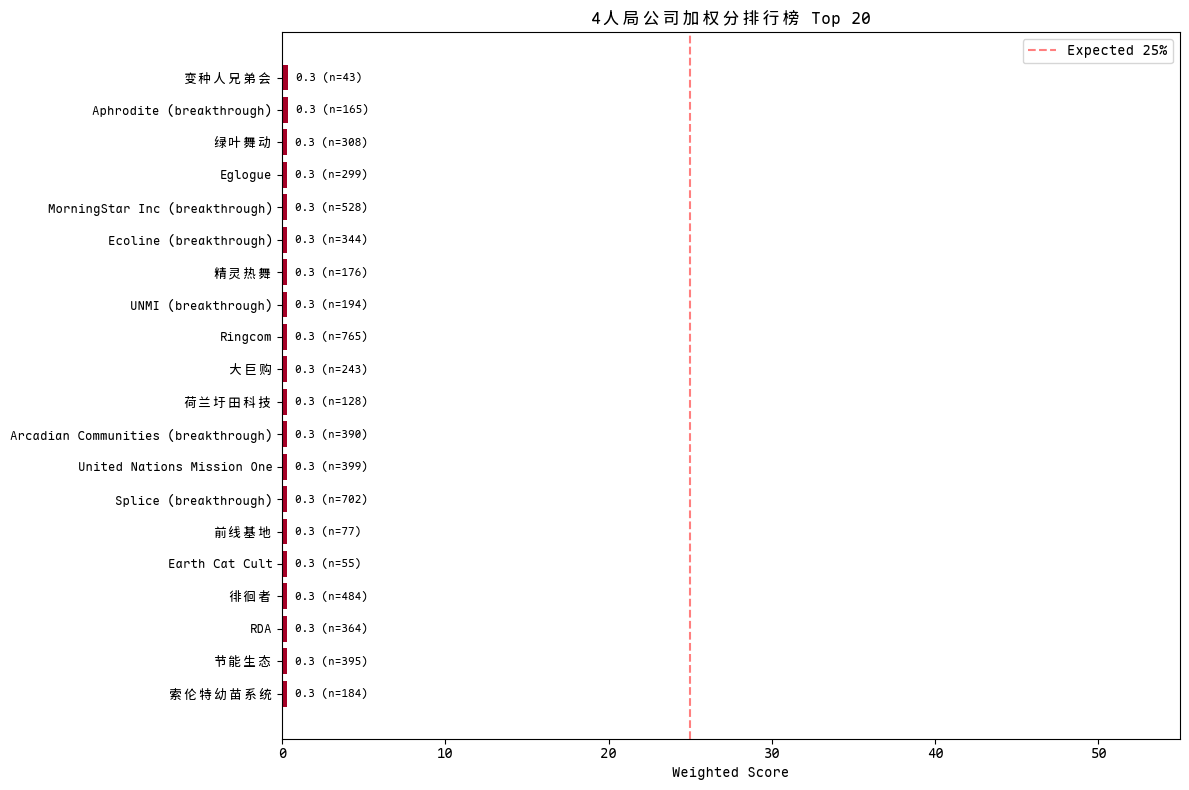

Saved: ./display/corporation_4p_weighted_mid_top20.png


In [6]:
# 1.2 公司平均顺位排行榜（4人局）
corp_4p = corp_usage_df[corp_usage_df['players'] == 4].copy()
corp_4p = add_cn_name_column(corp_4p, 'corporation', CN_MAP)
corp_4p_sorted = corp_4p.sort_values('weighted_avg_score', ascending=True)

print("=" * 60)
print("4人局公司平均顺位排行榜 (Top 20)")
print("=" * 60)
display(corp_4p_sorted.head(20))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
top20 = corp_4p_sorted.head(20)
colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('平均顺位')
ax.axvline(x=2.5, color='red', linestyle='--', alpha=0.5, label='期望 2.5 (4人局)')
ax.legend()
ax.set_title('4人局公司平均顺位排行榜 Top 20')
ax.set_xlim(1, 4)
for bar, score, games in zip(bars, top20['weighted_avg_score'], top20['total_games']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f} (n={games})', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('./display/corporation_4p_weighted_mid_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ./display/corporation_4p_weighted_mid_top20.png")

公司使用次数排行榜 (Top 30)


,corporation,total_games,wins,avg_score,weighted_avg_score,win_rate,cn_name,cn_name_plot
110,Valley Trust (breakthrough),1408,423,93.835938,1.041300,30.04,Valley Trust (breakthrough),Valley Trust (breakthrough)
76,Point Luna,1304,417,99.082055,1.108896,31.98,Point Luna,Point Luna
43,Interplanetary Cinematics (breakthrough),1167,404,88.995716,0.934319,34.62,Interplanetary Cinematics (breakthrough),Interplanetary Cinematics (breakthrough)
16,Celestic (breakthrough),1149,376,92.632724,1.046954,32.72,Celestic (breakthrough),Celestic (breakthrough)
99,Teractor (breakthrough),1106,322,92.503617,0.952712,29.11,Teractor (breakthrough),Teractor (breakthrough)
112,Vitor,1073,394,97.362535,0.886906,36.72,Vitor,Vitor
135,🌸Weyland Yutani🌸,1017,235,85.991150,0.535546,23.11,🌸韦兰德-尤坦尼集团🌸,韦兰德-尤坦尼集团
75,Pobolog (breakthrough),1009,322,92.672944,0.983300,31.91,Pobolog (breakthrough),Pobolog (breakthrough)
122,🌸Integrated Microorganisms🌸,927,305,91.834951,0.651025,32.90,🌸微生物星尘🌸,微生物星尘
130,🌸Shinra Tech🌸,919,270,91.052231,0.793417,29.38,🌸樱花电🌸,樱花电


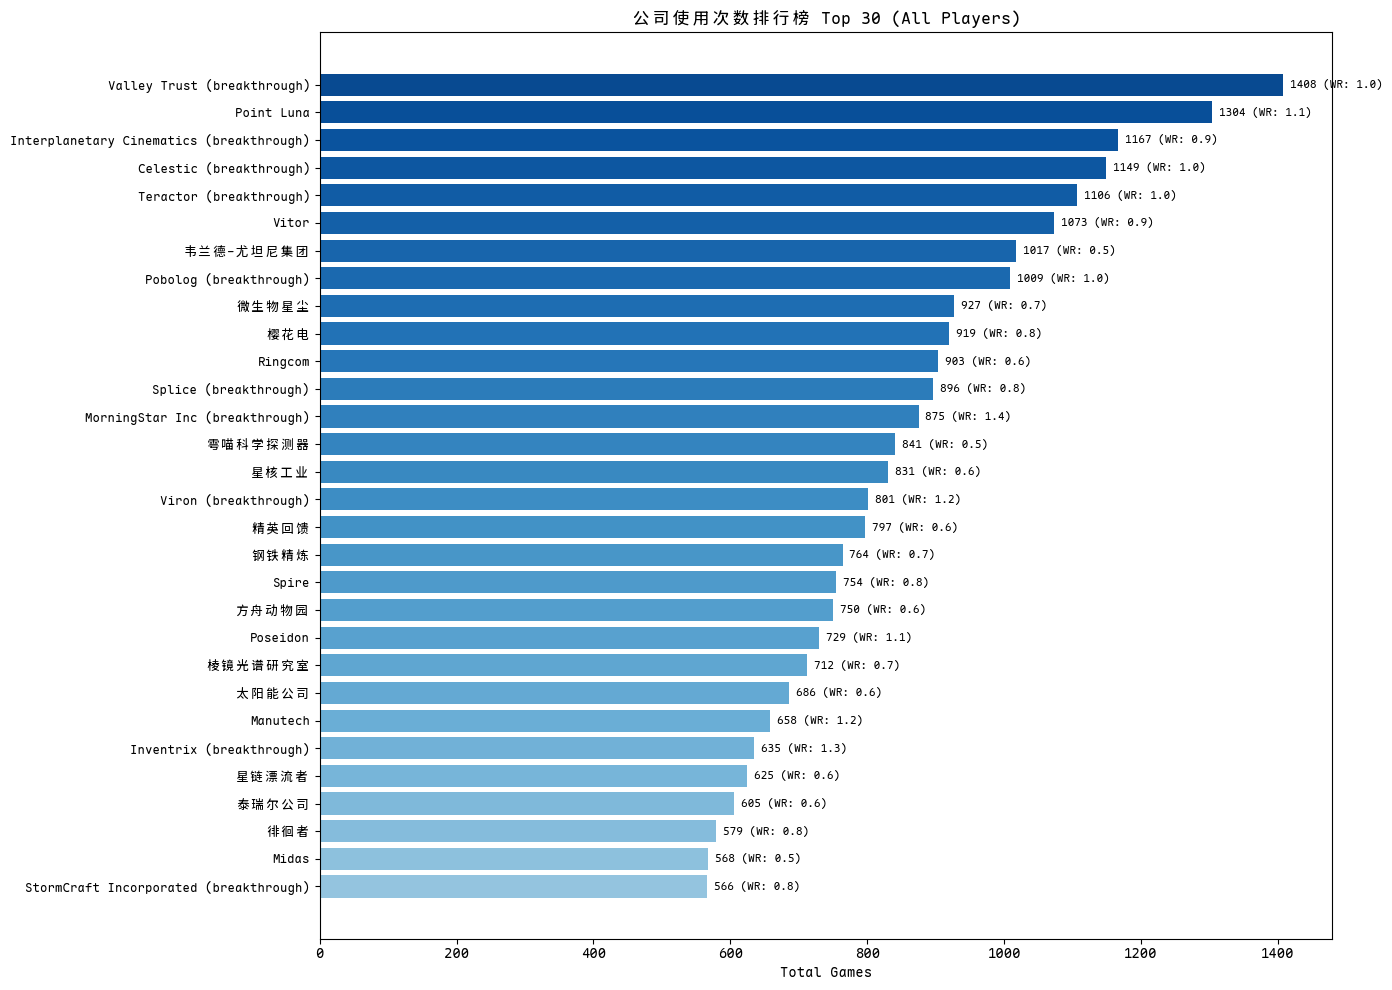

Saved: ./display/corporation_popularity_mid_top30.png


In [7]:
# 1.3 公司使用次数排行
corp_popular = corp_df.groupby('corporation').agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
).reset_index()

corp_popular['win_rate'] = (corp_popular['wins'] / corp_popular['total_games'] * 100).round(2)
corp_popular = corp_popular.sort_values('total_games', ascending=False)
corp_popular = add_cn_name_column(corp_popular, 'corporation', CN_MAP)

print("=" * 60)
print("公司使用次数排行榜 (Top 30)")
print("=" * 60)
display(corp_popular.head(30))

# Visualization
fig, ax = plt.subplots(figsize=(14, 10))
top30 = corp_popular.head(30)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30)))[::-1]
bars = ax.barh(range(len(top30)), top30['total_games'], color=colors)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Total Games')
ax.set_title('公司使用次数排行榜 Top 30 (All Players)')
for bar, games, ws in zip(bars, top30['total_games'], top30['weighted_avg_score']):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            f'{games} (WR: {ws:.1f})', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('./display/corporation_popularity_mid_top30.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ./display/corporation_popularity_mid_top30.png")

双公司组合平均顺位排行榜 (Top 20)


,combination,total_games,wins,avg_position,avg_score,weighted_avg_score,win_rate,cn_name_plot
144,Aphrodite (breakthrough) + Philares,7,6,1.285714,108.857143,7.235714,85.71,Aphrodite (breakthrough) +
1222,Ecoline (breakthrough) + PolderTECH Dutch,5,4,1.200000,75.000000,6.160000,80.00,Ecoline (breakthrough) + 荷兰圩田科技
1336,Factorum (breakthrough) + Mining guild (breakt...,6,3,1.833333,115.000000,5.883333,50.00,Factorum (breakthrough) + Mining guild (breakt...
3489,Tycho Magnetics + Viron (breakthrough),6,3,1.666667,137.666667,5.858333,50.00,第谷磁力 + Viron (breakthrough)
2021,Lakefront Resorts + UNMI (breakthrough),7,5,1.571429,80.000000,5.828571,71.43,湖畔度假区 + UNMI (breakthrough)
269,Aridor + Arklight (breakthrough),5,2,2.200000,83.400000,5.530000,40.00,Aridor + Arklight (breakthrough)
2588,Philares + 🌸Green Leaf Dance🌸,7,6,1.142857,107.857143,5.357143,85.71,+ 🌸绿叶舞动🌸
159,Aphrodite (breakthrough) + Spire,5,4,1.200000,116.000000,5.300000,80.00,Aphrodite (breakthrough) + Spire
2661,Pobolog (breakthrough) + Thorgate (breakthrough),6,3,1.500000,98.666667,5.050000,50.00,Pobolog (breakthrough) + Thorgate (breakthrough)
1580,Id Front + MorningStar Inc (breakthrough),7,5,1.285714,112.571429,4.542857,71.43,前线基地 + MorningStar Inc (breakthrough)


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/806997059.py:69: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/806997059.py:70: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  plt.savefig('./display/corporation_combo_mid_top20.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Maple Mono NF CN.
  fig.canvas.print_figure(bytes_io, **kw)


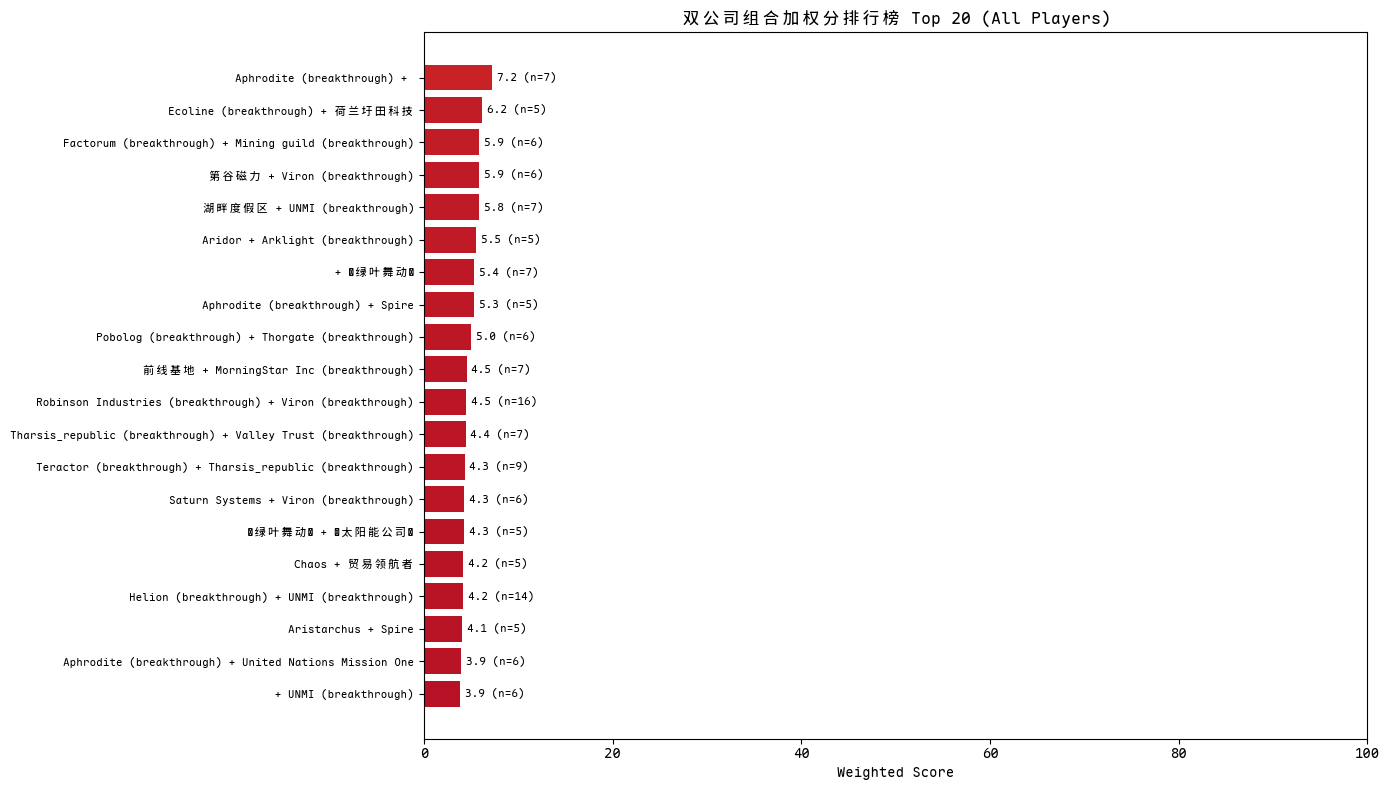

Saved: ./display/corporation_combo_mid_top20.png


In [8]:
# 1.4 双公司组合分析
def analyze_corp_combinations(ugr_df, min_games=5):
    """分析双公司组合"""
    combo_records = []

    for _, row in ugr_df[ugr_df['phase'] == 'end'].iterrows():
        corps = split_corporations(row['corporation'])
        if len(corps) >= 2:
            # 排序以确保组合唯一性
            combo = ' + '.join(sorted(corps[:2]))
            combo_records.append({
                'combination': combo,
                'corp1': sorted(corps[:2])[0],
                'corp2': sorted(corps[:2])[1],
                'position': row['position'],
                'player_score': row['player_score'],
                'players': row['players'],
                'generations': row['generations'],
                'weighted_score': calc_weighted_score(row['position'], row['players'])
            })

    if not combo_records:
        return pd.DataFrame()

    combo_df = pd.DataFrame(combo_records)

    # 统计组合表现
    combo_stats = combo_df.groupby('combination').agg(
        total_games=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
    ).reset_index()

    combo_stats['win_rate'] = (combo_stats['wins'] / combo_stats['total_games'] * 100).round(2)
    combo_stats = combo_stats[combo_stats['total_games'] >= min_games]

    return combo_stats.sort_values('weighted_avg_score', ascending=True)

corp_combo_df = analyze_corp_combinations(user_game_results_df)
if len(corp_combo_df) > 0:
    # Add cn_name column for combinations
    def get_combo_cn_name(combo):
        parts = combo.split(' + ')
        cn_parts = [CN_MAP.get(p, p) for p in parts]
        return ' + '.join(cn_parts)
    corp_combo_df['cn_name_plot'] = corp_combo_df['combination'].apply(get_combo_cn_name)

    print("=" * 60)
    print("双公司组合平均顺位排行榜 (Top 20)")
    print("=" * 60)
    display(corp_combo_df.head(20))

    # Visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    top20 = corp_combo_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_title('双公司组合平均顺位排行榜 Top 20 (All Players)')
    ax.set_xlim(1, 4)
    for bar, score, games in zip(bars, top20['weighted_avg_score'], top20['total_games']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={games})', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig('./display/corporation_combo_mid_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/corporation_combo_mid_top20.png")
else:
    print("未找到足够的双公司组合数据")

## 2. 前序卡分析 (Preludes)

前序卡数据需要从 `games.game` JSON 中提取：
- `players[].dealtPreludeCards` - 发到的前序牌
- `players[].playedCards` - 已打出卡牌（包含前序）

In [9]:
# 从 data/ 读取排除列表
# prelude, corporation, ceo 都需要从 project card 统计中排除

PRELUDE_FILE = './data/prelude_clean.txt'
CORPORATION_FILE = './data/corporation_clean.txt'
CEO_FILE = './data/ceo_clean.txt'

def load_card_set(filepath, card_type):
    """从文件加载卡牌集合"""
    cards = set()
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                name = line.strip()
                if name:
                    cards.add(name)
        print(f"从 {filepath} 加载了 {len(cards)} 种 {card_type}")
    except FileNotFoundError:
        print(f"警告: {filepath} 不存在，使用空 {card_type} 集合")
    return cards

# 加载 prelude, corporation, ceo 集合
KNOWN_PRELUDES = load_card_set(PRELUDE_FILE, 'prelude')
KNOWN_CORPORATIONS = load_card_set(CORPORATION_FILE, 'corporation')
KNOWN_CEOS = load_card_set(CEO_FILE, 'ceo')
print(f"Prelude 样例: {list(KNOWN_PRELUDES)[:5]}")
print(f"Corporation 样例: {list(KNOWN_CORPORATIONS)[:5]}")
print(f"CEO 样例: {list(KNOWN_CEOS)[:5]}")

def is_prelude(card_name):
    """判断是否为前序卡（基于预定义列表）"""
    return card_name in KNOWN_PRELUDES

def is_corporation(card_name):
    """判断是否为公司卡（基于预定义列表）"""
    return card_name in KNOWN_CORPORATIONS

def is_ceo(card_name):
    """判断是否为 CEO 卡（基于预定义列表）"""
    return card_name in KNOWN_CEOS



从 ./data/prelude_clean.txt 加载了 118 种 prelude
从 ./data/corporation_clean.txt 加载了 162 种 corporation
从 ./data/ceo_clean.txt 加载了 37 种 ceo
Prelude 样例: ['Huge Asteroid', 'Main Belt Asteroids', 'Metals Company', 'Underground Settlement', 'Project Eden']
Corporation 样例: ['Id Front', 'Luna First Incorporated', 'Eglogue', 'Spire', 'Arklight (breakthrough)']
CEO 样例: ['Neil', 'Rogers', 'Ulrich', 'Will', 'Karen']


In [10]:
# 从 games 表提取前序数据（如果 games_df 可用）
def extract_prelude_data(games_df, user_game_results_df):
    """从 games JSON 中提取前序卡数据"""
    if games_df is None or len(games_df) == 0:
        print("games 数据不可用，无法提取前序卡详细数据")
        return pd.DataFrame()

    prelude_records = []

    for _, row in games_df.iterrows():
        try:
            game_data = row['game']
            if isinstance(game_data, str):
                game_data = json.loads(game_data)

            game_id = row['game_id']

            for player in game_data.get('players', []):
                user_id = player.get('userId', '')
                player_name = player.get('name', '')

                # 从 playedCards 中提取前序
                played_cards = player.get('playedCards', [])
                for card in played_cards:
                    card_name = card.get('name', '')
                    if is_prelude(card_name):
                        prelude_records.append({
                            'game_id': game_id,
                            'user_id': user_id,
                            'player_name': player_name,
                            'prelude_name': card_name
                        })
        except Exception as e:
            continue

    if not prelude_records:
        return pd.DataFrame()

    prelude_df = pd.DataFrame(prelude_records)

    # 关联 user_game_results 获取胜负信息
    ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'][
        ['game_id', 'user_id', 'position', 'player_score', 'players', 'generations']
    ]

    prelude_df = prelude_df.merge(
        ugr_end,
        on=['game_id', 'user_id'],
        how='left'
    )

    # 计算加权分数
    prelude_df['weighted_score'] = prelude_df.apply(
        lambda row: calc_weighted_score(row['position'], row['players']), axis=1
    )

    return prelude_df

prelude_df = extract_prelude_data(games_df, user_game_results_df)
if len(prelude_df) > 0:
    print(f"提取到前序卡使用记录: {len(prelude_df)}")
    display(prelude_df.head(10))
else:
    print("无前序卡数据（需要 games 表的详细数据）")

提取到前序卡使用记录: 112029


,game_id,user_id,player_name,prelude_name,position,player_score,players,generations,weighted_score
0,g10030c944bf6,cec0e3f37580,hikaru,Mohole,2.0,79.0,4.0,6.0,0.30
1,g10030c944bf6,cec0e3f37580,hikaru,Early Colonization,2.0,79.0,4.0,6.0,0.30
2,g10030c944bf6,addb298f4557,风风,Soil Bacteria,1.0,80.0,4.0,6.0,0.50
3,g10030c944bf6,addb298f4557,风风,Space Lanes,1.0,80.0,4.0,6.0,0.50
4,g10030c944bf6,8068f8baa976,raaaay,Venus Contract,4.0,64.0,4.0,6.0,0.05
5,g10030c944bf6,8068f8baa976,raaaay,Aquifer Turbines,4.0,64.0,4.0,6.0,0.05
6,g10030c944bf6,c4f6ba391723,liyo,Power Generation,3.0,66.0,4.0,6.0,0.15
7,g10030c944bf6,c4f6ba391723,liyo,Double Down,3.0,66.0,4.0,6.0,0.15
8,g1004d7e6d1f8,,许壮( •̀ ω •́ )y,Space Lanes,NaN,NaN,NaN,NaN,0.00
9,g1004d7e6d1f8,,许壮( •̀ ω •́ )y,Donation,NaN,NaN,NaN,NaN,0.00


前序卡平均顺位排行榜


,prelude_name,total_uses,wins,avg_position,avg_score,weighted_avg_score,avg_generations,win_rate,cn_name,cn_name_plot
42,Free Trade Port,27,7,2.000000,107.727273,1.914815,7.727273,25.93,自由贸易港,自由贸易港
8,Basic Infrastructure,27,4,2.000000,108.000000,1.812963,9.294118,14.81,基础设施,基础设施
100,Underground Settlement,18,4,1.900000,94.100000,1.780556,7.600000,22.22,地下定居点,地下定居点
62,Mining Complex,32,12,1.791667,137.500000,1.681250,9.541667,37.50,矿业综合体,矿业综合体
26,Deepwater Dome,29,7,1.785714,104.714286,1.458621,8.000000,24.14,深水穹顶,深水穹顶
98,Tunneling Operation,28,7,1.833333,114.250000,1.319643,7.333333,25.00,隧道作业,隧道作业
56,Lunar Planning Office,41,11,1.846154,153.769231,1.253659,9.346154,26.83,月球规划办公室,月球规划办公室
17,Central Reservoir,19,1,2.500000,79.250000,1.213158,7.375000,5.26,中央水库,中央水库
21,Core Mine,41,10,1.920000,116.320000,1.147561,8.760000,24.39,核地雷,核地雷
66,Nitrate Reducers,446,126,2.055016,105.446602,0.979484,7.579288,28.25,硝酸盐还原剂,硝酸盐还原剂


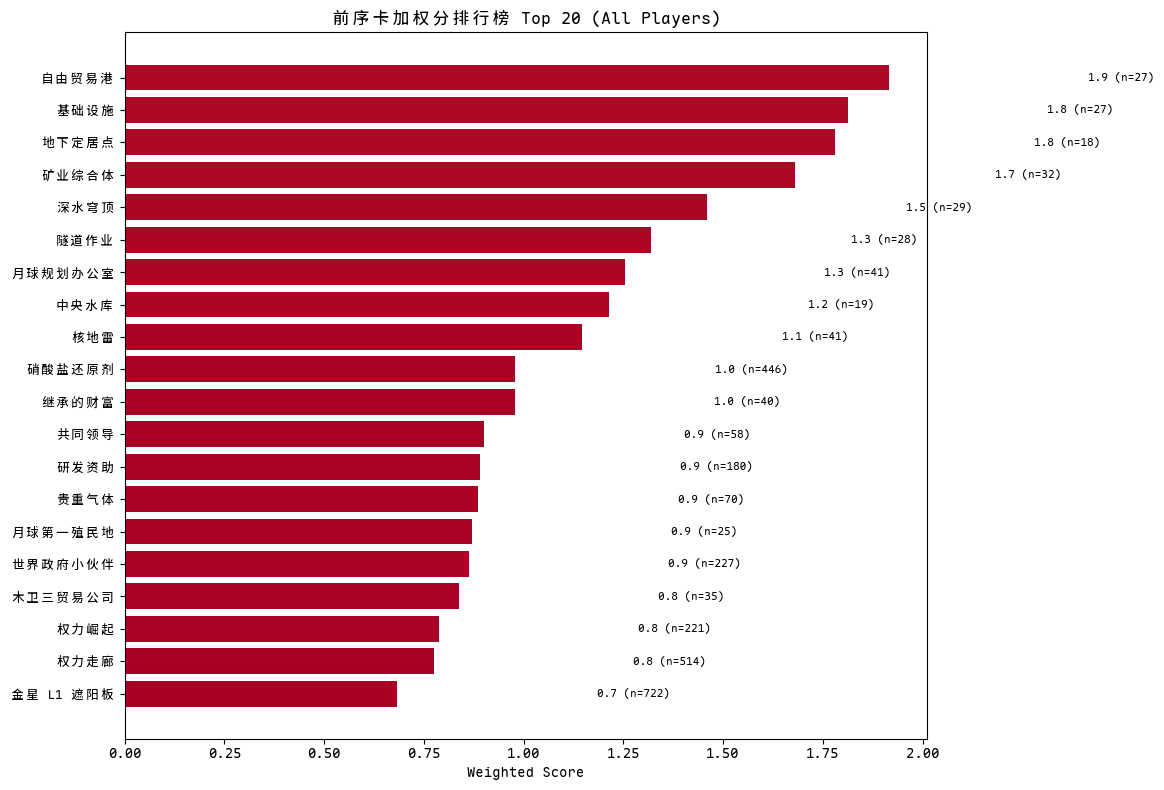

Saved: ./display/prelude_weighted_all_top20.png


In [11]:
# 2.1 前序卡使用率和胜率分析
def analyze_prelude_stats(prelude_df, min_games=10):
    """分析前序卡使用率和胜率"""
    if prelude_df is None or len(prelude_df) == 0:
        return pd.DataFrame()

    prelude_stats = prelude_df.groupby('prelude_name').agg(
        total_uses=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
        avg_generations=('generations', 'mean')
    ).reset_index()

    prelude_stats['win_rate'] = (prelude_stats['wins'] / prelude_stats['total_uses'] * 100).round(2)
    prelude_stats = prelude_stats[prelude_stats['total_uses'] >= min_games]

    return prelude_stats.sort_values('weighted_avg_score', ascending=True)

if len(prelude_df) > 0:
    prelude_stats_df = analyze_prelude_stats(prelude_df)
    prelude_stats_df = add_cn_name_column(prelude_stats_df, 'prelude_name', CN_MAP)
    print("=" * 60)
    print("前序卡平均顺位排行榜")
    print("=" * 60)
    display(prelude_stats_df.head(20))

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    top20 = prelude_stats_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
ax.set_xlim(1, 4)
    ax.set_title('前序卡平均顺位排行榜 Top 20 (All Players)')
    for bar, score, uses in zip(bars, top20['weighted_avg_score'], top20['total_uses']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={uses})', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig('./display/prelude_weighted_all_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/prelude_weighted_all_top20.png")

## 3. 打出的卡牌分析 (Played Cards)

从 `games.game` JSON 中提取 `players[].playedCards` 数据

In [12]:
# 从 games 表提取卡牌数据
def extract_played_cards(games_df, user_game_results_df):
    """从 games JSON 中提取已打出卡牌数据"""
    if games_df is None or len(games_df) == 0:
        print("games 数据不可用，无法提取卡牌详细数据")
        return pd.DataFrame()

    card_records = []

    for _, row in games_df.iterrows():
        try:
            game_data = row['game']
            if isinstance(game_data, str):
                game_data = json.loads(game_data)

            game_id = row['game_id']

            for player in game_data.get('players', []):
                user_id = player.get('userId', '')
                player_name = player.get('name', '')
                tr = player.get('terraformRating', 0)

                # 获取公司信息
                corporations = player.get('corporations', [])
                corp_names = [c.get('name', '') for c in corporations]

                # 提取所有打出的卡牌
                played_cards = player.get('playedCards', [])
                for card in played_cards:
                    card_name = card.get('name', '')
                    resource_count = card.get('resourceCount', 0)

                    card_records.append({
                        'game_id': game_id,
                        'user_id': user_id,
                        'player_name': player_name,
                        'card_name': card_name,
                        'resource_count': resource_count,
                        'terraform_rating': tr,
                        'corporation': '|'.join(corp_names),
                        'is_prelude': is_prelude(card_name),
                        'is_corporation': is_corporation(card_name),
                        'is_ceo': is_ceo(card_name)
                    })
        except Exception as e:
            continue

    if not card_records:
        return pd.DataFrame()

    card_df = pd.DataFrame(card_records)

    # 关联 user_game_results 获取胜负信息
    ugr_end = user_game_results_df[user_game_results_df['phase'] == 'end'][
        ['game_id', 'user_id', 'position', 'player_score', 'players', 'generations']
    ]

    card_df = card_df.merge(
        ugr_end,
        on=['game_id', 'user_id'],
        how='left'
    )

    # 计算加权分数
    card_df['weighted_score'] = card_df.apply(
        lambda row: calc_weighted_score(row['position'], row['players']), axis=1
    )

    return card_df

played_cards_df = extract_played_cards(games_df, user_game_results_df)
if len(played_cards_df) > 0:
    print(f"提取到卡牌使用记录: {len(played_cards_df)}")
    print(f"唯一卡牌数: {played_cards_df['card_name'].nunique()}")
    display(played_cards_df.head(10))
else:
    print("无卡牌数据（需要 games 表的详细数据）")

提取到卡牌使用记录: 2168102
唯一卡牌数: 1071


,game_id,user_id,player_name,card_name,resource_count,terraform_rating,corporation,is_prelude,is_corporation,is_ceo,position,player_score,players,generations,weighted_score
0,g10030c944bf6,cec0e3f37580,hikaru,Mohole,0,44,United Nations Mission One|Interplanetary Cine...,True,False,False,2.0,79.0,4.0,6.0,0.3
1,g10030c944bf6,cec0e3f37580,hikaru,Early Colonization,0,44,United Nations Mission One|Interplanetary Cine...,True,False,False,2.0,79.0,4.0,6.0,0.3
2,g10030c944bf6,cec0e3f37580,hikaru,Martian Fencing,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
3,g10030c944bf6,cec0e3f37580,hikaru,Subterranean Reservoir,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
4,g10030c944bf6,cec0e3f37580,hikaru,Deimos Down:ares,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
5,g10030c944bf6,cec0e3f37580,hikaru,Bribed Committee,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
6,g10030c944bf6,cec0e3f37580,hikaru,Technology Demonstration,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
7,g10030c944bf6,cec0e3f37580,hikaru,Desperate Measures,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
8,g10030c944bf6,cec0e3f37580,hikaru,Cow,7,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3
9,g10030c944bf6,cec0e3f37580,hikaru,Colonizer Training Camp,0,44,United Nations Mission One|Interplanetary Cine...,False,False,False,2.0,79.0,4.0,6.0,0.3


项目卡平均顺位排行榜 (Top 30)


,card_name,play_count,game_count,wins,avg_position,avg_score,weighted_avg_score,avg_resources,win_rate,cn_name,cn_name_plot
623,Space Privateers,13,13,3,1.857143,140.571429,2.003846,3.384615,23.08,太空私掠者,太空私掠者
201,Family Connections,12,12,3,1.000000,229.666667,1.750000,0.000000,25.00,家族关系,家族关系
268,Heavy Duty Rovers,60,60,21,1.738095,180.357143,1.746667,0.000000,35.00,重型漫游车,重型漫游车
335,L.T.F. Privileges,53,53,24,1.564103,208.333333,1.721698,0.000000,45.28,L.T.F.特权,L.T.F.特权
98,Colonist Shuttles,78,78,32,1.557692,162.615385,1.667949,0.000000,41.03,殖民者穿梭机,殖民者穿梭机
366,Luna Staging Station,112,112,46,1.513514,180.351351,1.574107,0.000000,41.07,月球中转站,月球中转站
362,Luna Political Institute,75,75,34,1.367347,166.285714,1.568667,0.000000,45.33,月球政治研究所,月球政治研究所
682,Thorium Rush,148,148,49,1.677083,155.489583,1.511486,0.000000,33.11,钍金属狂潮,钍金属狂潮
363,Luna Project Office,173,173,54,1.761468,153.944954,1.507225,0.000000,31.21,月球项目办公室,月球项目办公室
451,Mooncrate Convoys To Mars,16,16,6,1.636364,174.090909,1.506250,0.000000,37.50,月球运输队前往火星,月球运输队前往火星


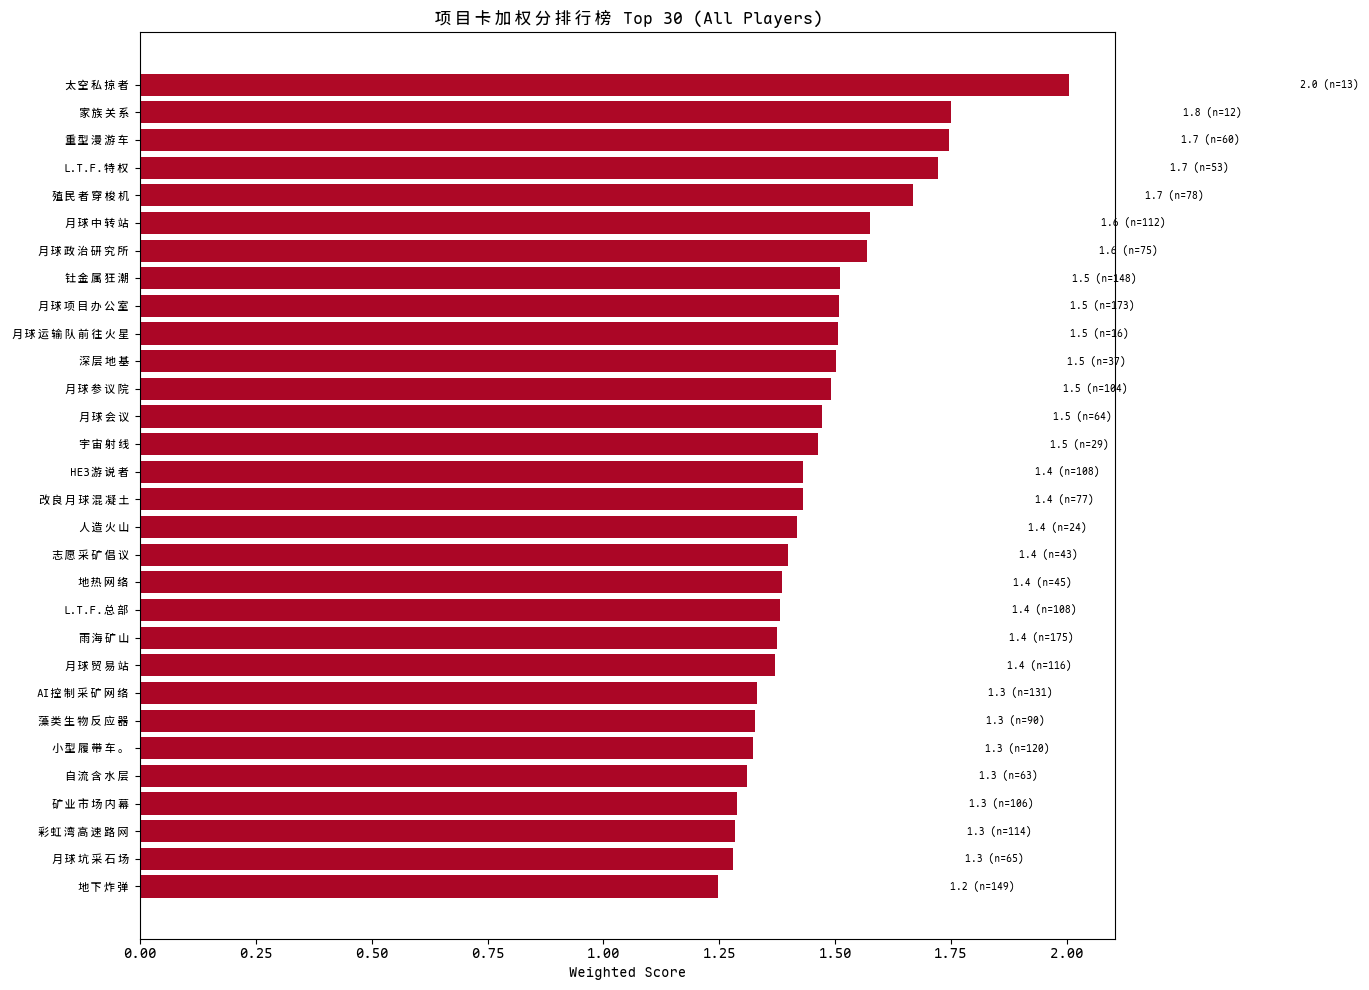

Saved: ./display/card_weighted_all_top30.png


In [13]:
# 3.1 卡牌打出率和胜率分析
def analyze_card_stats(card_df, min_games=10):
    """分析卡牌打出率和胜率"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    # 排除前序卡，只分析项目卡
    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    card_stats = project_cards_df.groupby('card_name').agg(
        play_count=('game_id', 'count'),
        game_count=('game_id', 'nunique'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
        avg_resources=('resource_count', 'mean')
    ).reset_index()

    card_stats['win_rate'] = (card_stats['wins'] / card_stats['play_count'] * 100).round(2)
    card_stats = card_stats[card_stats['play_count'] >= min_games]

    return card_stats

if len(played_cards_df) > 0:
    card_stats_df = analyze_card_stats(played_cards_df)
    card_stats_df = add_cn_name_column(card_stats_df, 'card_name', CN_MAP)

    # 按胜率排序
    print("=" * 60)
    print("项目卡平均顺位排行榜 (Top 30)")
    print("=" * 60)
    card_stats_by_wr = card_stats_df.sort_values('weighted_avg_score', ascending=True)
    display(card_stats_by_wr.head(30))

    # Visualization - Weighted Score
    fig, ax = plt.subplots(figsize=(14, 10))
    top30 = card_stats_by_wr.head(30)
    colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top30)))
    ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
ax.set_xlim(1, 4)
    ax.set_title('项目卡平均顺位排行榜 Top 30 (All Players)')
    for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_weighted_all_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_weighted_all_top30.png")

项目卡使用次数排行榜 (Top 30)


,card_name,play_count,game_count,wins,avg_position,avg_score,weighted_avg_score,avg_resources,win_rate,cn_name,cn_name_plot
559,Research Outpost,8292,8292,1234,1.997653,113.942675,0.455264,0.000000,14.88,科研前哨站,科研前哨站
670,Technology Demonstration,8204,8204,1130,2.103483,110.875290,0.404900,0.000000,13.77,科学论证,科学论证
482,Olympus Conference,8083,8083,1258,2.032882,113.994197,0.439917,0.545961,15.56,奥林巴斯峰会,奥林巴斯峰会
555,Research,8023,8023,1101,2.076762,112.555827,0.421096,0.000000,13.72,研究,研究
397,Mars University,7938,7938,1173,2.071762,113.212283,0.432496,0.000000,14.78,火星大学,火星大学
338,Lagrange Observatory,7891,7891,1054,2.147959,109.014626,0.420143,0.000000,13.36,拉格朗日观察点,拉格朗日观察点
7,Advanced Alloys,7734,7734,1053,2.077794,115.308985,0.390490,0.000000,13.62,优化合金,优化合金
612,Solar Wind Power,7729,7729,1097,2.046569,112.998578,0.436512,0.000000,14.19,太阳风,太阳风
169,Earth Catapult,7679,7679,1248,1.929900,119.260014,0.487453,0.000000,16.25,地球发射站,地球发射站
625,Space Station,7647,7647,1076,2.099581,112.223969,0.426206,0.000000,14.07,空间站,空间站


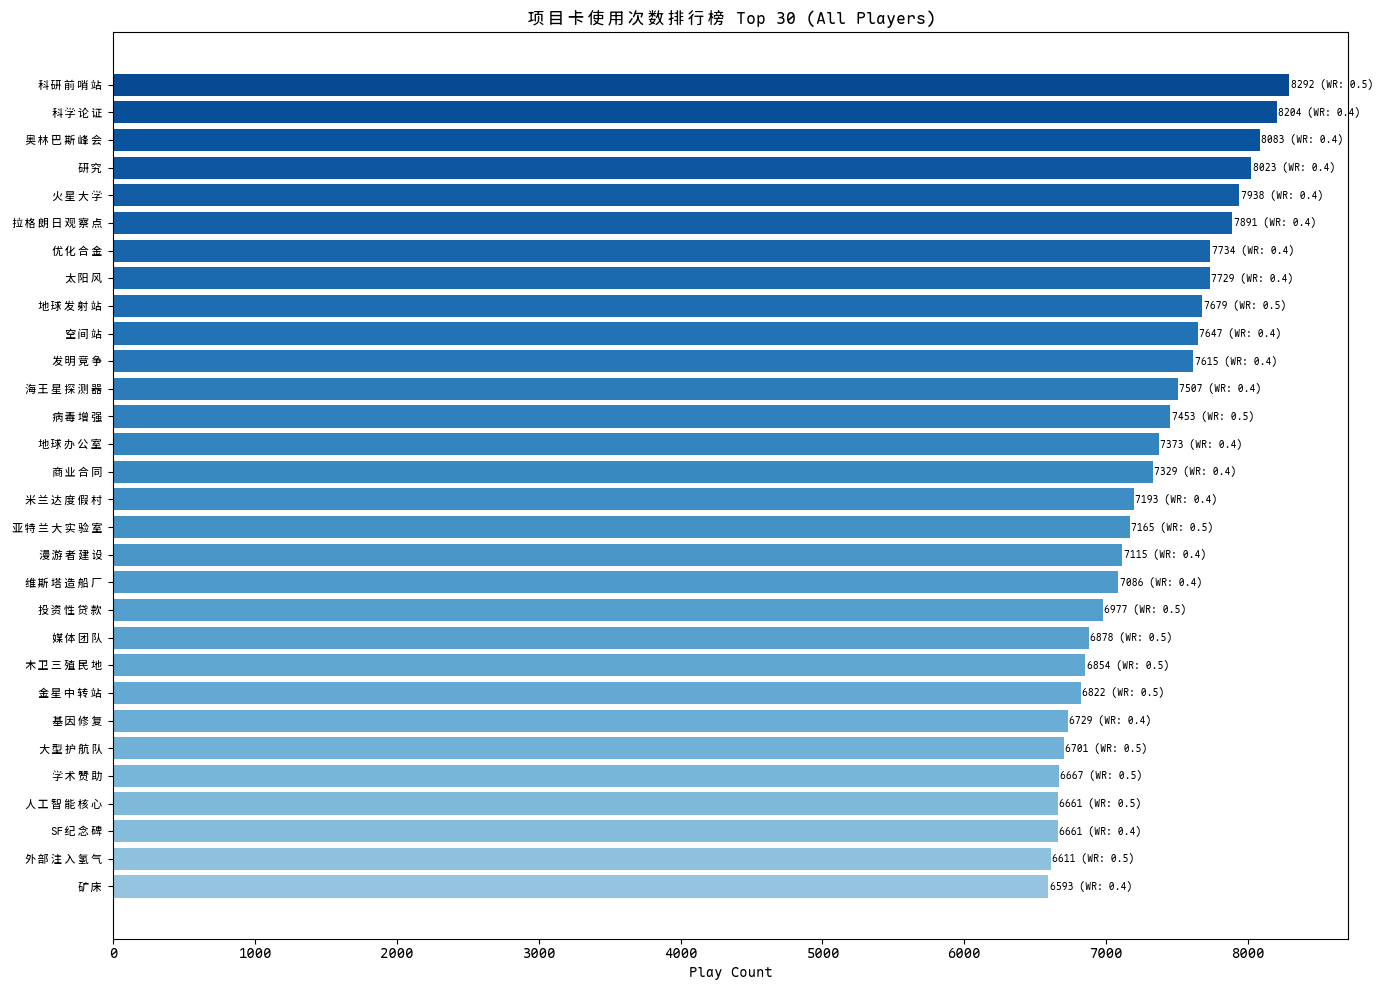

Saved: ./display/card_playcount_all_top30.png


In [14]:
# 3.2 卡牌使用次数排行
if len(played_cards_df) > 0:
    print("=" * 60)
    print("项目卡使用次数排行榜 (Top 30)")
    print("=" * 60)
    card_stats_by_count = card_stats_df.sort_values('play_count', ascending=False)
    display(card_stats_by_count.head(30))

    # Visualization - Play Count
    fig, ax = plt.subplots(figsize=(14, 10))
    top30 = card_stats_by_count.head(30)
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30)))[::-1]
    bars = ax.barh(range(len(top30)), top30['play_count'], color=colors)
    ax.set_yticks(range(len(top30)))
    ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Play Count')
    ax.set_title('项目卡使用次数排行榜 Top 30 (All Players)')
    for bar, count, ws in zip(bars, top30['play_count'], top30['weighted_avg_score']):
        ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                f'{count} (WR: {ws:.1f})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_playcount_all_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_playcount_all_top30.png")

4人局项目卡平均顺位排行榜 (Top 20)


,card_name,players,play_count,wins,avg_position,avg_score,weighted_avg_score,win_rate,cn_name,cn_name_plot
2138,Off-World Tax Haven,4.0,5,4,1.200000,105.600000,0.460000,80.00,外星避税天堂,外星避税天堂
3172,Underground Railway,4.0,5,4,1.400000,117.200000,0.430000,80.00,地下铁路,地下铁路
1342,Induced Tremor,4.0,8,5,1.375000,99.500000,0.425000,62.50,诱发震颤,诱发震颤
95,Algae Bioreactors,4.0,8,6,1.500000,117.875000,0.418750,75.00,藻类生物反应器,藻类生物反应器
1617,Luna Political Institute,4.0,9,6,1.555556,110.000000,0.405556,66.67,月球政治研究所,月球政治研究所
2623,Sinus Irdium Road Network,4.0,9,5,1.666667,141.222222,0.383333,55.56,彩虹湾高速路网,彩虹湾高速路网
158,Artesian Aquifer,4.0,8,5,1.750000,106.375000,0.375000,62.50,自流含水层,自流含水层
1406,Investigative Journalism,4.0,8,4,1.750000,107.375000,0.368750,50.00,调查性新闻,调查性新闻
1630,Luna Senate,4.0,10,4,1.700000,128.100000,0.365000,40.00,月球参议院,月球参议院
2007,Mooncrate Block Factory,4.0,6,3,1.833333,129.500000,0.358333,50.00,月球坑采石场,月球坑采石场


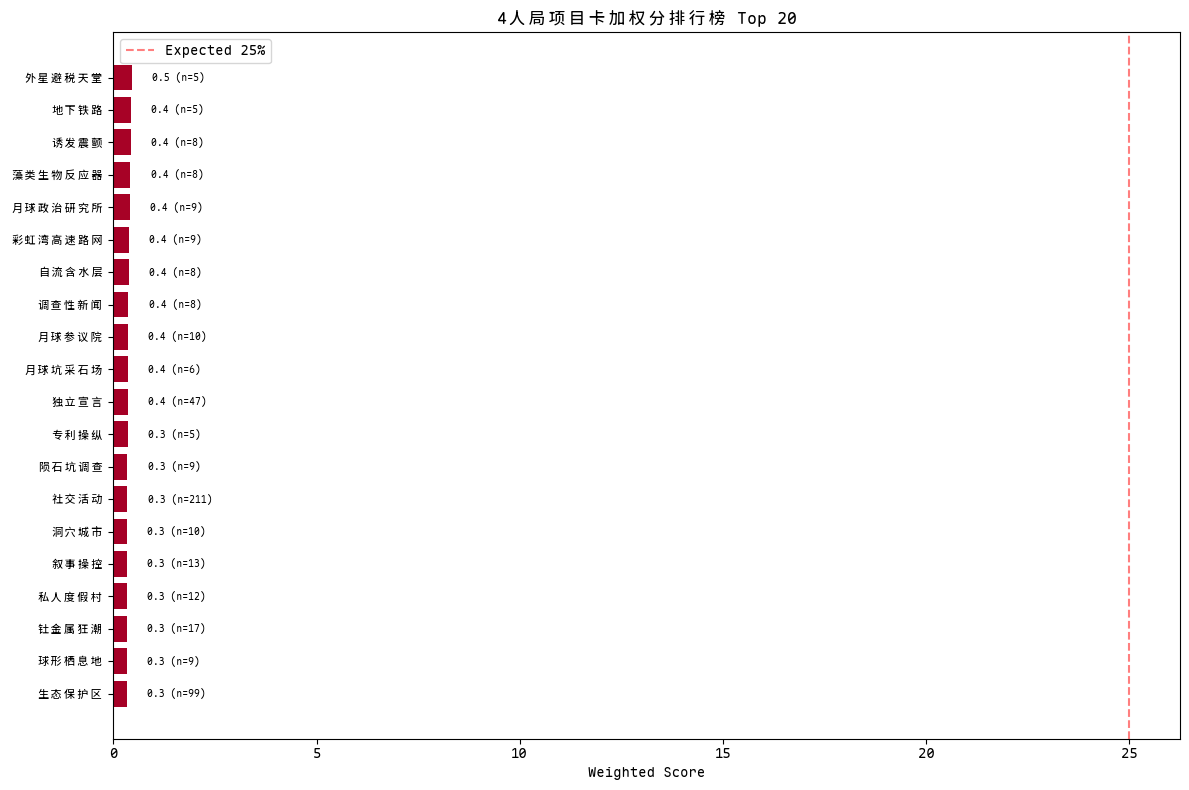

Saved: ./display/card_4p_weighted_mid_top20.png


In [15]:
# 3.3 卡牌与玩家人数的关系
def analyze_card_by_players(card_df, min_games=5):
    """按玩家人数分析卡牌表现"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    card_by_players = project_cards_df.groupby(['card_name', 'players']).agg(
        play_count=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
    ).reset_index()

    card_by_players['win_rate'] = (card_by_players['wins'] / card_by_players['play_count'] * 100).round(2)
    card_by_players = card_by_players[card_by_players['play_count'] >= min_games]

    return card_by_players

if len(played_cards_df) > 0:
    card_by_players_df = analyze_card_by_players(played_cards_df)
    card_by_players_df = add_cn_name_column(card_by_players_df, 'card_name', CN_MAP)

    # 4人局卡牌排行
    print("=" * 60)
    print("4人局项目卡平均顺位排行榜 (Top 20)")
    print("=" * 60)
    card_4p_df = card_by_players_df[card_by_players_df['players'] == 4].sort_values('weighted_avg_score', ascending=True)
    display(card_4p_df.head(20))

    # Visualization - 4P Card Weighted Score
    fig, ax = plt.subplots(figsize=(12, 8))
    top20 = card_4p_df.head(20)
    colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
    bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
ax.set_xlim(1, 4)
    ax.axvline(x=2.5, color='red', linestyle='--', alpha=0.5, label='期望 2.5 (4人局)')
    ax.legend()
    ax.set_title('4人局项目卡平均顺位排行榜 Top 20')
    for bar, score, count in zip(bars, top20['weighted_avg_score'], top20['play_count']):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)
    plt.tight_layout()
    plt.savefig('./display/card_4p_weighted_mid_top20.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ./display/card_4p_weighted_mid_top20.png")

卡牌-公司协同加权分排行 (Top 30)


,card_name,corporation,play_count,wins,avg_score,weighted_avg_score,win_rate,card_cn_name,corp_cn_name,card_cn_name_plot,corp_cn_name_plot
67896,Public Celebrations,Septem Tribus,5,2,91.800000,6.510000,40.00,公开庆典,Septem Tribus,公开庆典,Septem Tribus
380,AI Controlled Mine Network,Terralabs Research (breakthrough),5,3,139.800000,5.833333,60.00,AI控制采矿网络,Terralabs Research (breakthrough),AI控制采矿网络,Terralabs Research (breakthrough)
86685,Thorium Rush,🌸Tyrell🌸,7,3,125.428571,5.714286,42.86,钍金属狂潮,🌸泰瑞尔公司🌸,钍金属狂潮,泰瑞尔公司
46449,Luna Project Office,Celestic (breakthrough),5,4,169.400000,5.400000,80.00,月球项目办公室,Celestic (breakthrough),月球项目办公室,Celestic (breakthrough)
86487,Thiolava Vents,Brotherhood of Mutants,5,5,198.600000,5.250000,100.00,硫熔岩喷口,变种人兄弟会,硫熔岩喷口,变种人兄弟会
86682,Thorium Rush,🌸Shinra Tech🌸,6,5,143.666667,5.214286,83.33,钍金属狂潮,🌸樱花电🌸,钍金属狂潮,樱花电
24185,Envoys From Venus,Ecoline (breakthrough),5,2,93.600000,5.050000,40.00,金星来使,Ecoline (breakthrough),金星来使,Ecoline (breakthrough)
51165,Martian Media Center,Aristarchus,5,2,113.200000,5.000000,40.00,火星媒体中心,Aristarchus,火星媒体中心,Aristarchus
60377,Ocean City,Aurorai,7,5,126.714286,4.621429,71.43,海洋城市,Aurorai,海洋城市,Aurorai
17438,Cyberia Systems,Recyclon (breakthrough),7,5,121.142857,4.600000,71.43,赛博利亚系统,Recyclon (breakthrough),赛博利亚系统,Recyclon (breakthrough)


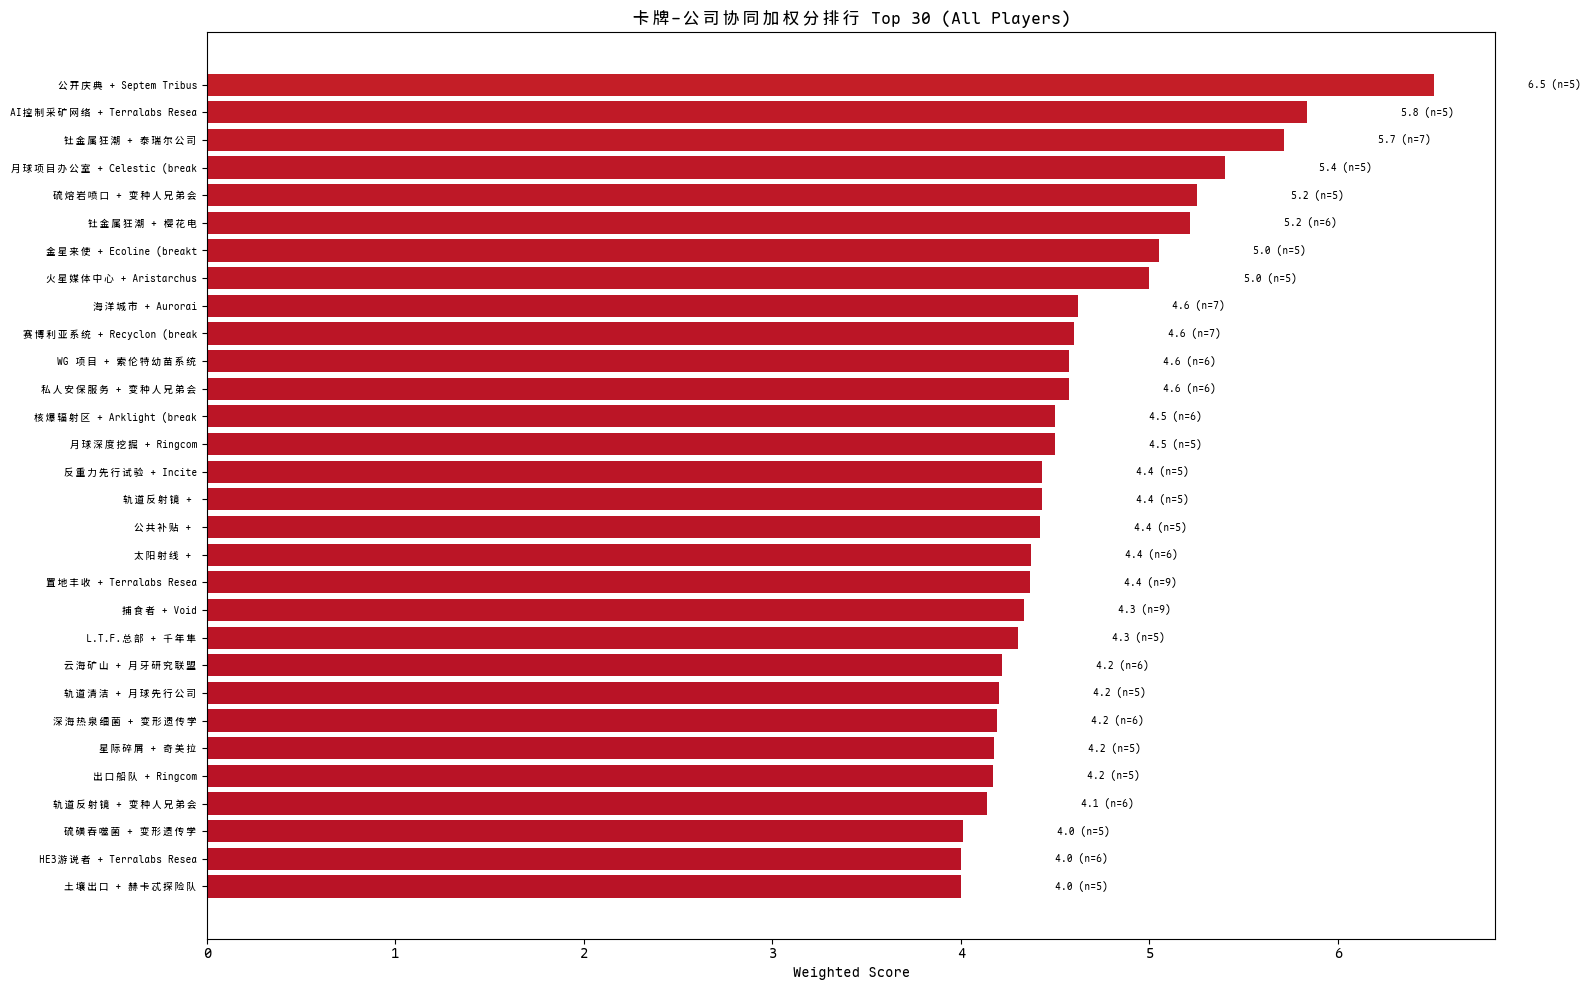

Saved: ./display/card_corp_synergy_all_top30.png


In [16]:
# 3.4 卡牌与公司的关联分析
def analyze_card_corporation_synergy(card_df, min_games=5):
    """分析卡牌与公司的协同效果"""
    if card_df is None or len(card_df) == 0:
        return pd.DataFrame()

    project_cards_df = card_df[(~card_df['is_prelude']) & (~card_df['is_corporation']) & (~card_df['is_ceo'])].copy()

    # 展开公司
    synergy_records = []
    for _, row in project_cards_df.iterrows():
        corps = split_corporations(row['corporation'])
        for corp in corps:
            synergy_records.append({
                'card_name': row['card_name'],
                'corporation': corp,
                'position': row['position'],
                'player_score': row['player_score'],
                'weighted_score': row['weighted_score']
            })

    if not synergy_records:
        return pd.DataFrame()

    synergy_df = pd.DataFrame(synergy_records)

    synergy_stats = synergy_df.groupby(['card_name', 'corporation']).agg(
        play_count=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
    ).reset_index()

    synergy_stats['win_rate'] = (synergy_stats['wins'] / synergy_stats['play_count'] * 100).round(2)
    synergy_stats = synergy_stats[synergy_stats['play_count'] >= min_games]

    return synergy_stats.sort_values('weighted_avg_score', ascending=True)

if len(played_cards_df) > 0:
    synergy_df = analyze_card_corporation_synergy(played_cards_df)
    if len(synergy_df) > 0:
        # Add cn_name columns
        synergy_df['card_cn_name'] = synergy_df['card_name'].apply(lambda x: CN_MAP.get(x, x))
        synergy_df['corp_cn_name'] = synergy_df['corporation'].apply(lambda x: CN_MAP.get(x, x))
        # Add plot-safe versions (without emoji)
        synergy_df['card_cn_name_plot'] = synergy_df['card_name'].apply(lambda x: get_cn_name_for_plot(x, CN_MAP))
        synergy_df['corp_cn_name_plot'] = synergy_df['corporation'].apply(lambda x: get_cn_name_for_plot(x, CN_MAP))

        print("=" * 60)
        print("卡牌-公司协同加权分排行 (Top 30)")
        print("=" * 60)
        display(synergy_df.head(30))

        # Visualization
        fig, ax = plt.subplots(figsize=(16, 10))
        top30 = synergy_df.head(30)
        labels = [f"{strip_emoji(row['card_cn_name'])[:15]} + {strip_emoji(row['corp_cn_name'])[:15]}" for _, row in top30.iterrows()]
        colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
        bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top30)))
        ax.set_yticklabels(labels, fontsize=7)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
ax.set_xlim(1, 4)
        ax.set_title('卡牌-公司协同加权分排行 Top 30 (All Players)')
        for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={count})', va='center', fontsize=7)
        plt.tight_layout()
        plt.savefig('./display/card_corp_synergy_all_top30.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: ./display/card_corp_synergy_all_top30.png")

## 4. 数据导出

In [17]:
# 导出分析结果到 CSV
OUTPUT_DIR = './analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 导出公司数据
if len(corp_usage_df) > 0:
    corp_usage_df.to_csv(f'{OUTPUT_DIR}/corporation_usage.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_usage.csv")

if len(corp_popular) > 0:
    corp_popular.to_csv(f'{OUTPUT_DIR}/corporation_popularity.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_popularity.csv")

if len(corp_combo_df) > 0:
    corp_combo_df.to_csv(f'{OUTPUT_DIR}/corporation_combinations.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/corporation_combinations.csv")

# 导出前序数据
if 'prelude_stats_df' in dir() and len(prelude_stats_df) > 0:
    prelude_stats_df.to_csv(f'{OUTPUT_DIR}/prelude_stats.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/prelude_stats.csv")

# 导出卡牌数据
if 'card_stats_df' in dir() and len(card_stats_df) > 0:
    card_stats_df.to_csv(f'{OUTPUT_DIR}/card_stats.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/card_stats.csv")

if 'card_by_players_df' in dir() and len(card_by_players_df) > 0:
    card_by_players_df.to_csv(f'{OUTPUT_DIR}/card_stats_by_players.csv', index=False)
    print(f"已导出: {OUTPUT_DIR}/card_stats_by_players.csv")

print("\n数据导出完成!")

已导出: ./analysis_results/corporation_usage.csv
已导出: ./analysis_results/corporation_popularity.csv
已导出: ./analysis_results/corporation_combinations.csv
已导出: ./analysis_results/prelude_stats.csv
已导出: ./analysis_results/card_stats.csv
已导出: ./analysis_results/card_stats_by_players.csv

数据导出完成!


## 5. 汇总统计

In [18]:
# 汇总统计信息
print("=" * 60)
print("数据分析汇总")
print("=" * 60)

print(f"\n1. 公司数据:")
print(f"   - 总公司使用记录: {len(corp_df)}")
print(f"   - 唯一公司数量: {corp_df['corporation'].nunique()}")
if len(corp_usage_df) > 0:
    print(f"   - 分析的公司数量 (>=10局): {len(corp_usage_df['corporation'].unique())}")

if len(corp_combo_df) > 0:
    print(f"\n2. 双公司组合:")
    print(f"   - 分析的组合数量: {len(corp_combo_df)}")

if 'prelude_df' in dir() and len(prelude_df) > 0:
    print(f"\n3. 前序卡数据:")
    print(f"   - 总前序使用记录: {len(prelude_df)}")
    print(f"   - 唯一前序数量: {prelude_df['prelude_name'].nunique()}")

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    print(f"\n4. 卡牌数据:")
    print(f"   - 总卡牌使用记录: {len(played_cards_df)}")
    print(f"   - 唯一卡牌数量: {played_cards_df['card_name'].nunique()}")
    project_count = len(played_cards_df[(~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])])
    print(f"   - 项目卡使用记录: {project_count}")

数据分析汇总

1. 公司数据:
   - 总公司使用记录: 45955
   - 唯一公司数量: 137
   - 分析的公司数量 (>=10局): 114

2. 双公司组合:
   - 分析的组合数量: 1276

3. 前序卡数据:
   - 总前序使用记录: 112029
   - 唯一前序数量: 109

4. 卡牌数据:
   - 总卡牌使用记录: 2168102
   - 唯一卡牌数量: 1071
   - 项目卡使用记录: 2023829


## 6. Export to Display Folder and Visualizations

In [19]:
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

DISPLAY_DIR = './display'
os.makedirs(DISPLAY_DIR, exist_ok=True)

# Minimum sample size for filtered data
MIN_SAMPLE_SIZE = 10

print(f"Display folder created: {DISPLAY_DIR}")
print(f"Minimum sample size for filtered data: {MIN_SAMPLE_SIZE}")

Display folder created: ./display
Minimum sample size for filtered data: 10


Saved: ./display/corporation_usage_full.csv (569 rows)
Saved: ./display/corporation_usage_filtered.csv (348 rows)
Saved: ./display/corporation_4p_weighted_full.csv (135 rows)
Saved: ./display/corporation_4p_weighted_filtered.csv (109 rows)


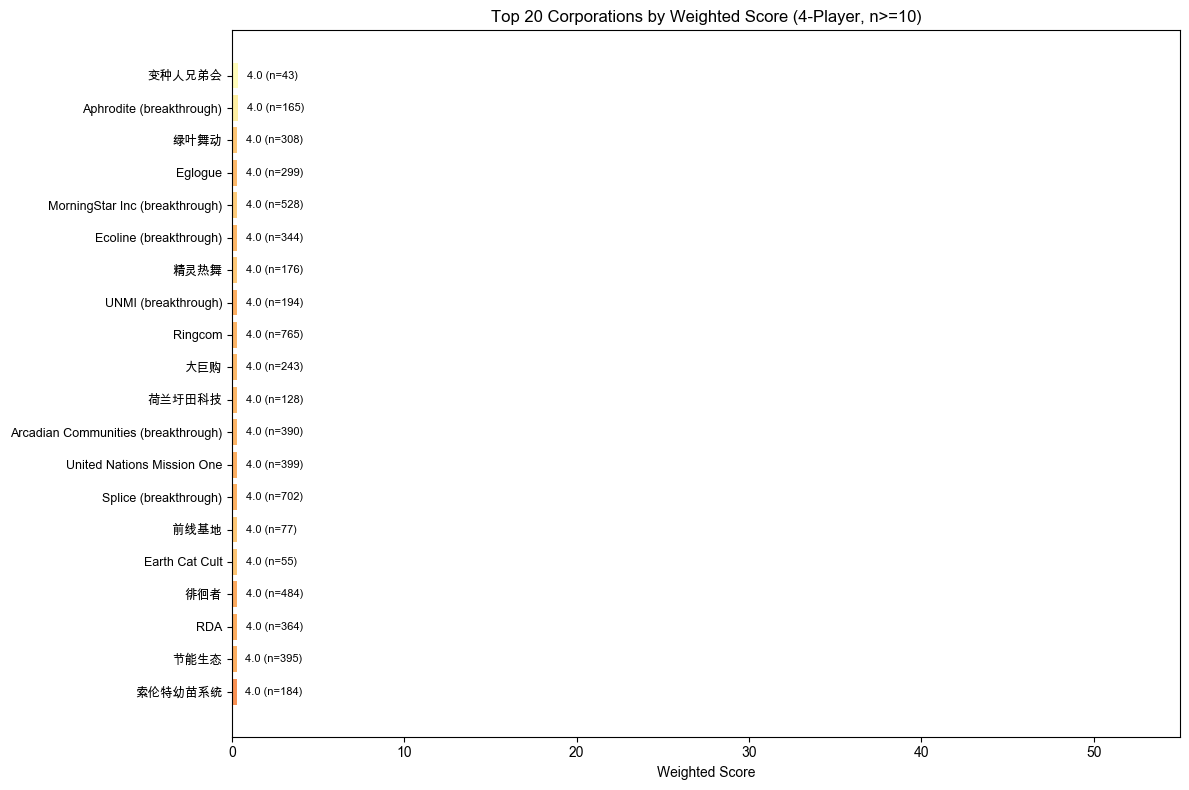

Saved: ./display/corporation_4p_weighted_top20.png


In [20]:
# 6.1 Save Corporation Usage Data (Full + Filtered) and Visualize

# Re-analyze corporation usage without min_games filter for full version
corp_usage_full = corp_df.groupby(['corporation', 'players']).agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_position=('position', 'mean'),
    avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
    avg_generations=('generations', 'mean')
).reset_index()
corp_usage_full['win_rate'] = (corp_usage_full['wins'] / corp_usage_full['total_games'] * 100).round(2)
corp_usage_full = corp_usage_full.sort_values(['players', 'weighted_avg_score'], ascending=[True, True])

# Add cn_name column
corp_usage_full = add_cn_name_column(corp_usage_full, 'corporation', CN_MAP)

# Save FULL corporation usage data (no filter)
corp_usage_full.to_csv(f'{DISPLAY_DIR}/corporation_usage_full.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_usage_full.csv ({len(corp_usage_full)} rows)")

# Save FILTERED corporation usage data (>= MIN_SAMPLE_SIZE)
corp_usage_filtered = corp_usage_full[corp_usage_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
corp_usage_filtered.to_csv(f'{DISPLAY_DIR}/corporation_usage_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_usage_filtered.csv ({len(corp_usage_filtered)} rows)")

# 4-player data - Full and Filtered
corp_4p_full = corp_usage_full[corp_usage_full['players'] == 4].sort_values('weighted_avg_score', ascending=True)
corp_4p_filtered = corp_usage_filtered[corp_usage_filtered['players'] == 4].sort_values('weighted_avg_score', ascending=True)

corp_4p_full.to_csv(f'{DISPLAY_DIR}/corporation_4p_weighted_full.csv', index=False)
corp_4p_filtered.to_csv(f'{DISPLAY_DIR}/corporation_4p_weighted_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_full.csv ({len(corp_4p_full)} rows)")
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_filtered.csv ({len(corp_4p_filtered)} rows)")

# Visualization: Top 20 Corporations by 平均顺位 (4-player) - FILTERED DATA
fig, ax = plt.subplots(figsize=(12, 8))
top20_4p = corp_4p_filtered.head(20)
colors = plt.cm.RdYlGn(top20_4p['win_rate'] / 100)
bars = ax.barh(range(len(top20_4p)), top20_4p['weighted_avg_score'], color=colors)
ax.set_yticks(range(len(top20_4p)))
ax.set_yticklabels(top20_4p['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('平均顺位')
ax.set_title(f'Top 20 Corporations by 平均顺位 (4-Player, n>={MIN_SAMPLE_SIZE})')
ax.set_xlim(1, 4)

for i, (bar, rate, games) in enumerate(zip(bars, top20_4p['weighted_avg_score'], top20_4p['total_games'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f} (n={games})', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_4p_weighted_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_4p_weighted_top20.png")

Saved: ./display/corporation_popularity_full.csv (135 rows)
Saved: ./display/corporation_popularity_filtered.csv (109 rows)


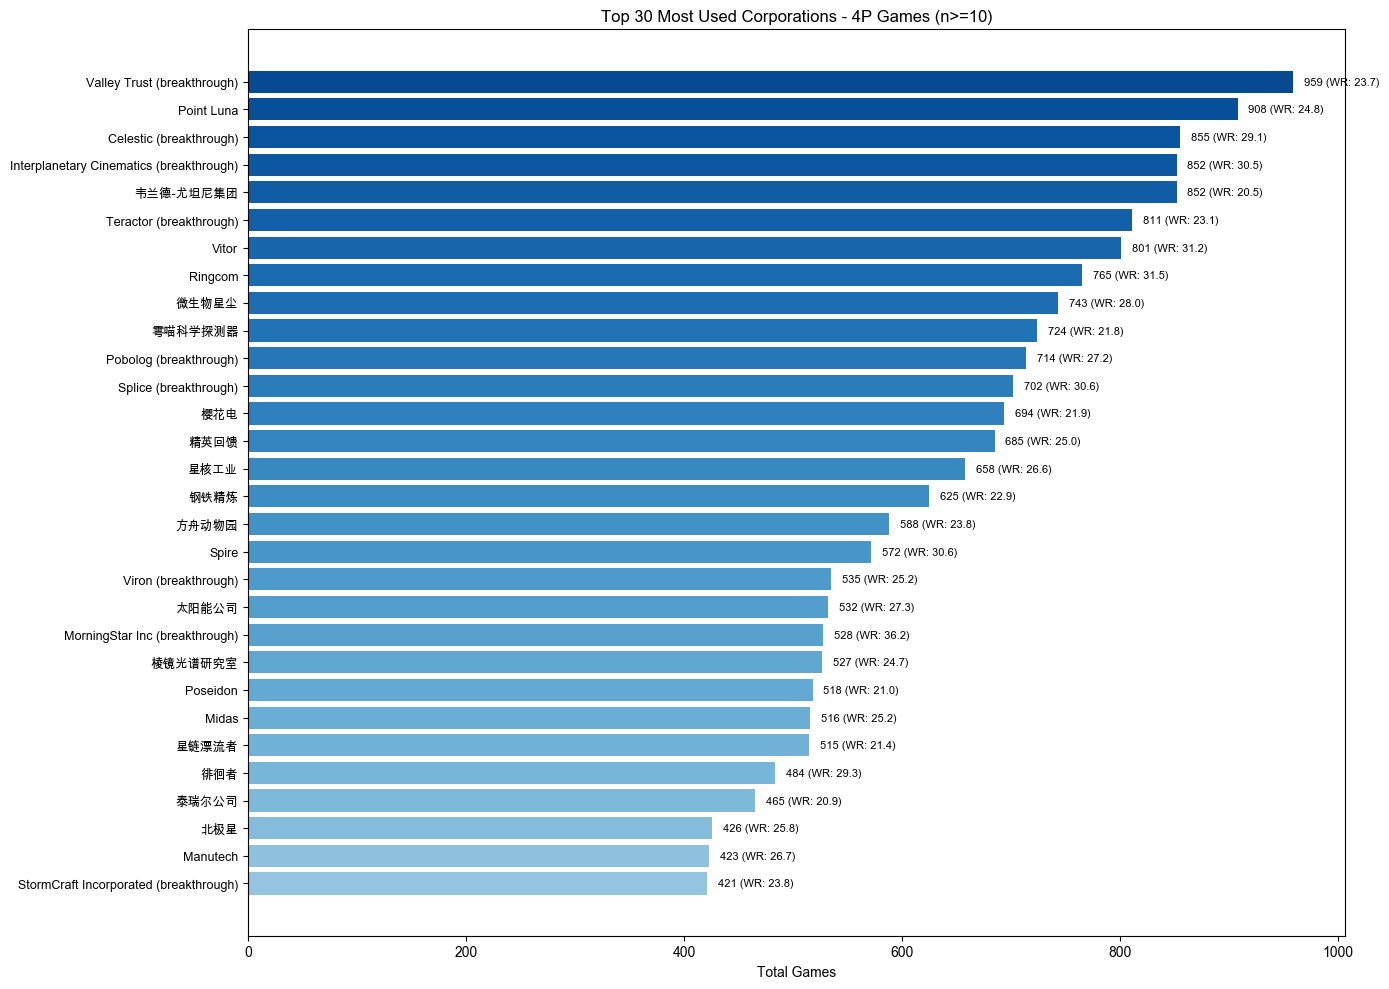

Saved: ./display/corporation_popularity_top30.png


In [21]:
# 6.2 Save Corporation Popularity Data (Full + Filtered) and Visualize
# 只使用4人局数据计算胜率，避免单人局100%胜率干扰

# Filter to 4-player games only for accurate win rate calculation
corp_df_4p = corp_df[corp_df['players'] == 4].copy()

# Re-calculate corporation popularity using 4-player games only
corp_popular_full = corp_df_4p.groupby('corporation').agg(
    total_games=('game_id', 'count'),
    wins=('position', lambda x: (x == 1).sum()),
    avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
).reset_index()
corp_popular_full['win_rate'] = (corp_popular_full['wins'] / corp_popular_full['total_games'] * 100).round(2)
corp_popular_full = corp_popular_full.sort_values('total_games', ascending=False)

# Add cn_name column
corp_popular_full = add_cn_name_column(corp_popular_full, 'corporation', CN_MAP)

# Save FULL corporation popularity data
corp_popular_full.to_csv(f'{DISPLAY_DIR}/corporation_popularity_full.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_full.csv ({len(corp_popular_full)} rows)")

# Save FILTERED corporation popularity data
corp_popular_filtered = corp_popular_full[corp_popular_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
corp_popular_filtered.to_csv(f'{DISPLAY_DIR}/corporation_popularity_filtered.csv', index=False)
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_filtered.csv ({len(corp_popular_filtered)} rows)")

# Visualization: Top 30 Most Used Corporations - FILTERED DATA
fig, ax = plt.subplots(figsize=(14, 10))
top30_popular = corp_popular_filtered.head(30)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top30_popular)))[::-1]
bars = ax.barh(range(len(top30_popular)), top30_popular['total_games'], color=colors)
ax.set_yticks(range(len(top30_popular)))
ax.set_yticklabels(top30_popular['cn_name_plot'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Total Games')
ax.set_title(f'Top 30 Most Used Corporations - 4P Games (n>={MIN_SAMPLE_SIZE})')

for bar, games, ws in zip(bars, top30_popular['total_games'], top30_popular['win_rate']):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            f'{games} (WR: {ws:.1f})', va='center', fontsize=8)

ax.set_xlim(1, 4)
plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_popularity_top30.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_popularity_top30.png")

Saved: ./display/corporation_combinations_full.csv (3880 rows)
Saved: ./display/corporation_combinations_filtered.csv (598 rows)


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/756161937.py:65: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/756161937.py:66: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.savefig(f'{DISPLAY_DIR}/corporation_combinations_top20.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)


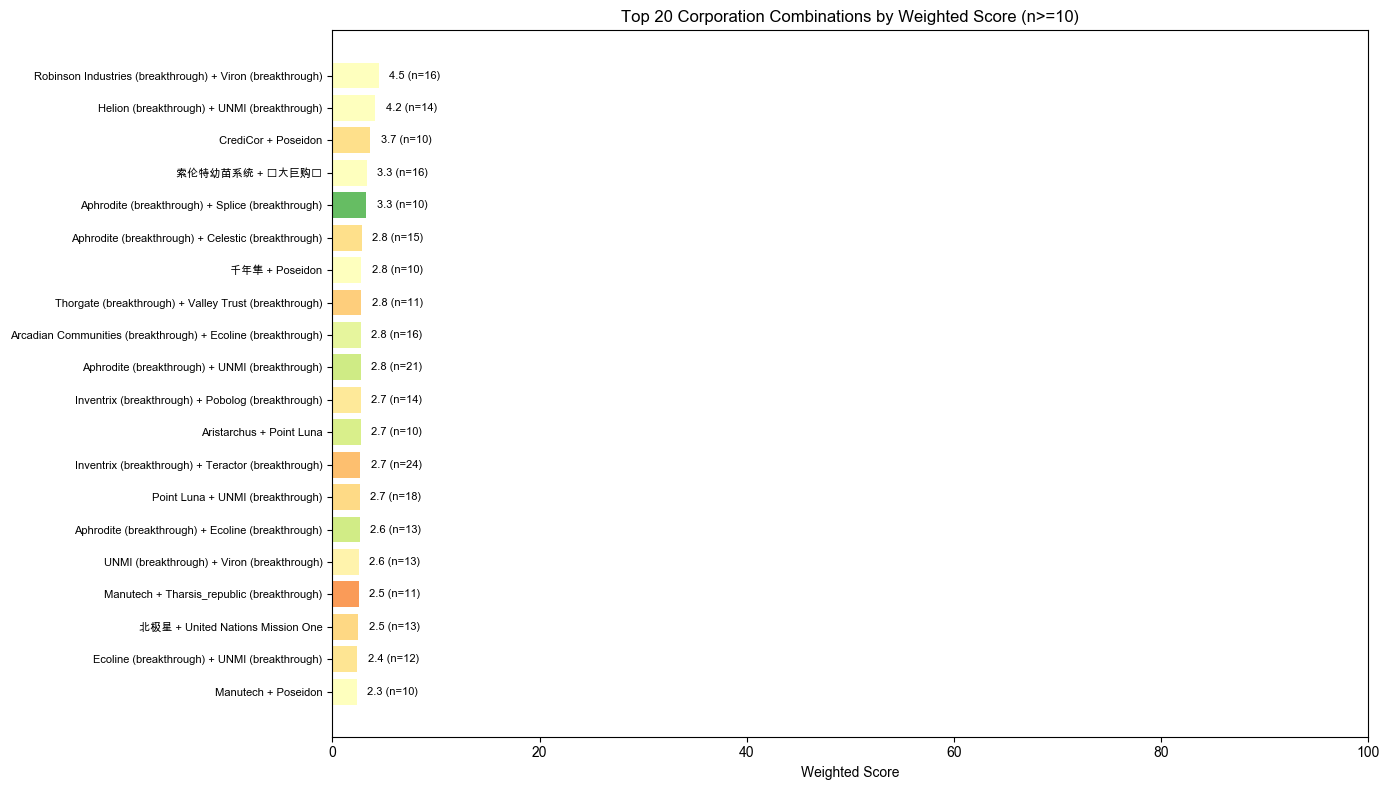

Saved: ./display/corporation_combinations_top20.png


In [22]:
# 6.3 Save Corporation Combinations Data (Full + Filtered) and Visualize

# Re-analyze combinations without filter for full version
combo_records = []
for _, row in user_game_results_df[user_game_results_df['phase'] == 'end'].iterrows():
    corps = split_corporations(row['corporation'])
    if len(corps) >= 2:
        combo = ' + '.join(sorted(corps[:2]))
        combo_records.append({
            'combination': combo,
            'corp1': sorted(corps[:2])[0],
            'corp2': sorted(corps[:2])[1],
            'position': row['position'],
            'player_score': row['player_score'],
            'players': row['players'],
            'generations': row['generations'],
            'weighted_score': row['weighted_score']
        })

if combo_records:
    combo_df_temp = pd.DataFrame(combo_records)
    corp_combo_full = combo_df_temp.groupby('combination').agg(
        total_games=('position', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
    ).reset_index()
    corp_combo_full['win_rate'] = (corp_combo_full['wins'] / corp_combo_full['total_games'] * 100).round(2)
    corp_combo_full = corp_combo_full.sort_values('weighted_avg_score', ascending=True)

    # Add cn_name column (for combination, we'll translate each corp separately)
    def get_combo_cn_name(combo):
        parts = combo.split(' + ')
        cn_parts = [CN_MAP.get(p, p) for p in parts]
        return ' + '.join(cn_parts)
    corp_combo_full['cn_name_plot'] = corp_combo_full['combination'].apply(get_combo_cn_name)

    # Save FULL combination data
    corp_combo_full.to_csv(f'{DISPLAY_DIR}/corporation_combinations_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/corporation_combinations_full.csv ({len(corp_combo_full)} rows)")

    # Save FILTERED combination data
    corp_combo_filtered = corp_combo_full[corp_combo_full['total_games'] >= MIN_SAMPLE_SIZE].copy()
    corp_combo_filtered.to_csv(f'{DISPLAY_DIR}/corporation_combinations_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/corporation_combinations_filtered.csv ({len(corp_combo_filtered)} rows)")

    # Visualization: Top 20 Corporation Combinations - FILTERED DATA
    if len(corp_combo_filtered) > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        top20_combo = corp_combo_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_combo['win_rate'] / 100)
        bars = ax.barh(range(len(top20_combo)), top20_combo['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_combo)))
        ax.set_yticklabels(top20_combo['cn_name_plot'], fontsize=8)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Corporation Combinations by 平均顺位 (n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, games in zip(bars, top20_combo['weighted_avg_score'], top20_combo['total_games']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={games})', va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/corporation_combinations_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/corporation_combinations_top20.png")
else:
    print("No corporation combination data available")

Saved: ./display/prelude_usage_raw.csv (112029 rows)
Saved: ./display/prelude_stats_full.csv (109 rows)
Saved: ./display/prelude_stats_filtered.csv (91 rows)


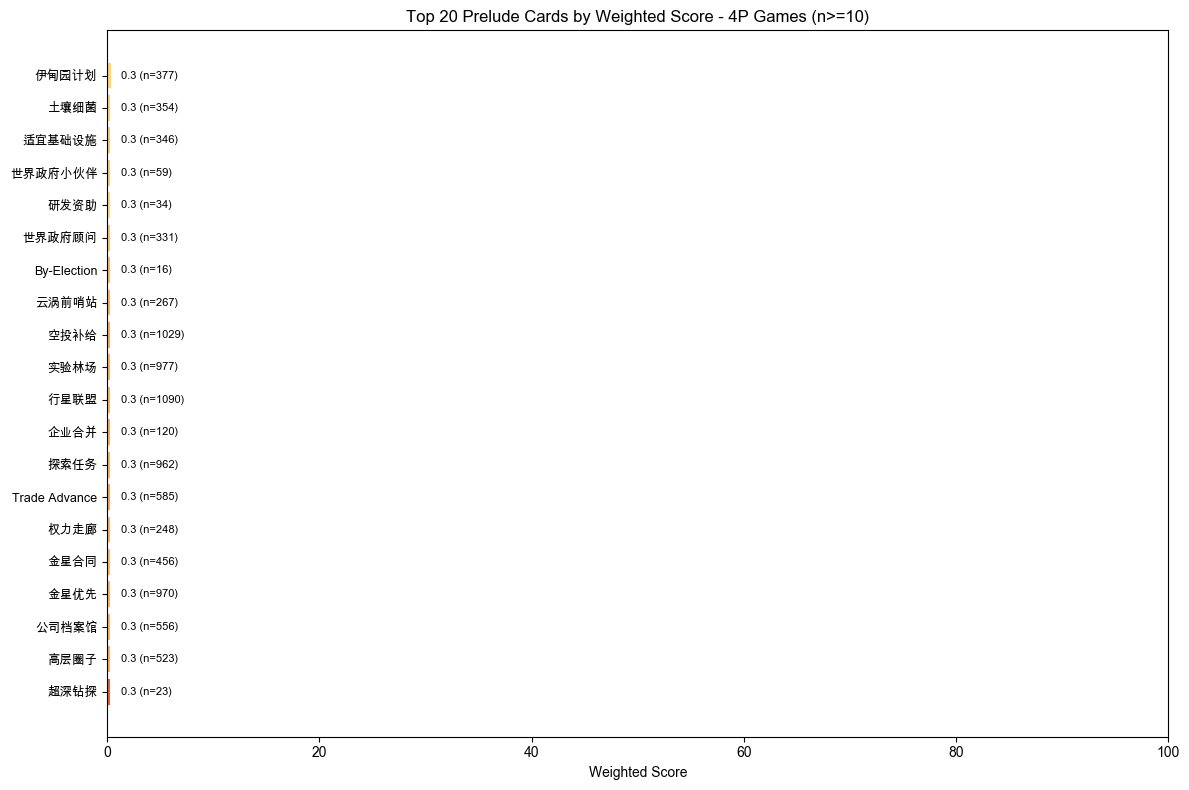

Saved: ./display/prelude_weighted_top20.png


In [23]:
# 6.4 Save Prelude Stats Data (Full + Filtered) and Visualize

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Save raw prelude data
    prelude_df.to_csv(f'{DISPLAY_DIR}/prelude_usage_raw.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_usage_raw.csv ({len(prelude_df)} rows)")

    # Re-analyze prelude stats using 4-player games only for accurate win rate
    prelude_df_4p = prelude_df[prelude_df['players'] == 4].copy()
    prelude_stats_full = prelude_df_4p.groupby('prelude_name').agg(
        total_uses=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
        avg_generations=('generations', 'mean')
    ).reset_index()
    prelude_stats_full['win_rate'] = (prelude_stats_full['wins'] / prelude_stats_full['total_uses'] * 100).round(2)
    prelude_stats_full = prelude_stats_full.sort_values('weighted_avg_score', ascending=True)

    # Add cn_name column
    prelude_stats_full = add_cn_name_column(prelude_stats_full, 'prelude_name', CN_MAP)

    # Save FULL prelude stats data
    prelude_stats_full.to_csv(f'{DISPLAY_DIR}/prelude_stats_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_stats_full.csv ({len(prelude_stats_full)} rows)")

    # Save FILTERED prelude stats data
    prelude_stats_filtered = prelude_stats_full[prelude_stats_full['total_uses'] >= MIN_SAMPLE_SIZE].copy()
    prelude_stats_filtered.to_csv(f'{DISPLAY_DIR}/prelude_stats_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/prelude_stats_filtered.csv ({len(prelude_stats_filtered)} rows)")

    # Visualization: Top 20 Preludes by Weighted Score - FILTERED DATA
    if len(prelude_stats_filtered) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        top20_prelude = prelude_stats_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_prelude['win_rate'] / 100)
        bars = ax.barh(range(len(top20_prelude)), top20_prelude['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_prelude)))
        ax.set_yticklabels(top20_prelude['cn_name_plot'], fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Prelude Cards by Weighted Score - 4P Games (n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, uses in zip(bars, top20_prelude['weighted_avg_score'], top20_prelude['total_uses']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={uses})', va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/prelude_weighted_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/prelude_weighted_top20.png")
else:
    print("No prelude data available")

Saved: ./display/played_cards_raw.csv (2168102 rows)
Saved: ./display/card_stats_full.csv (758 rows)
Saved: ./display/card_stats_filtered.csv (664 rows)


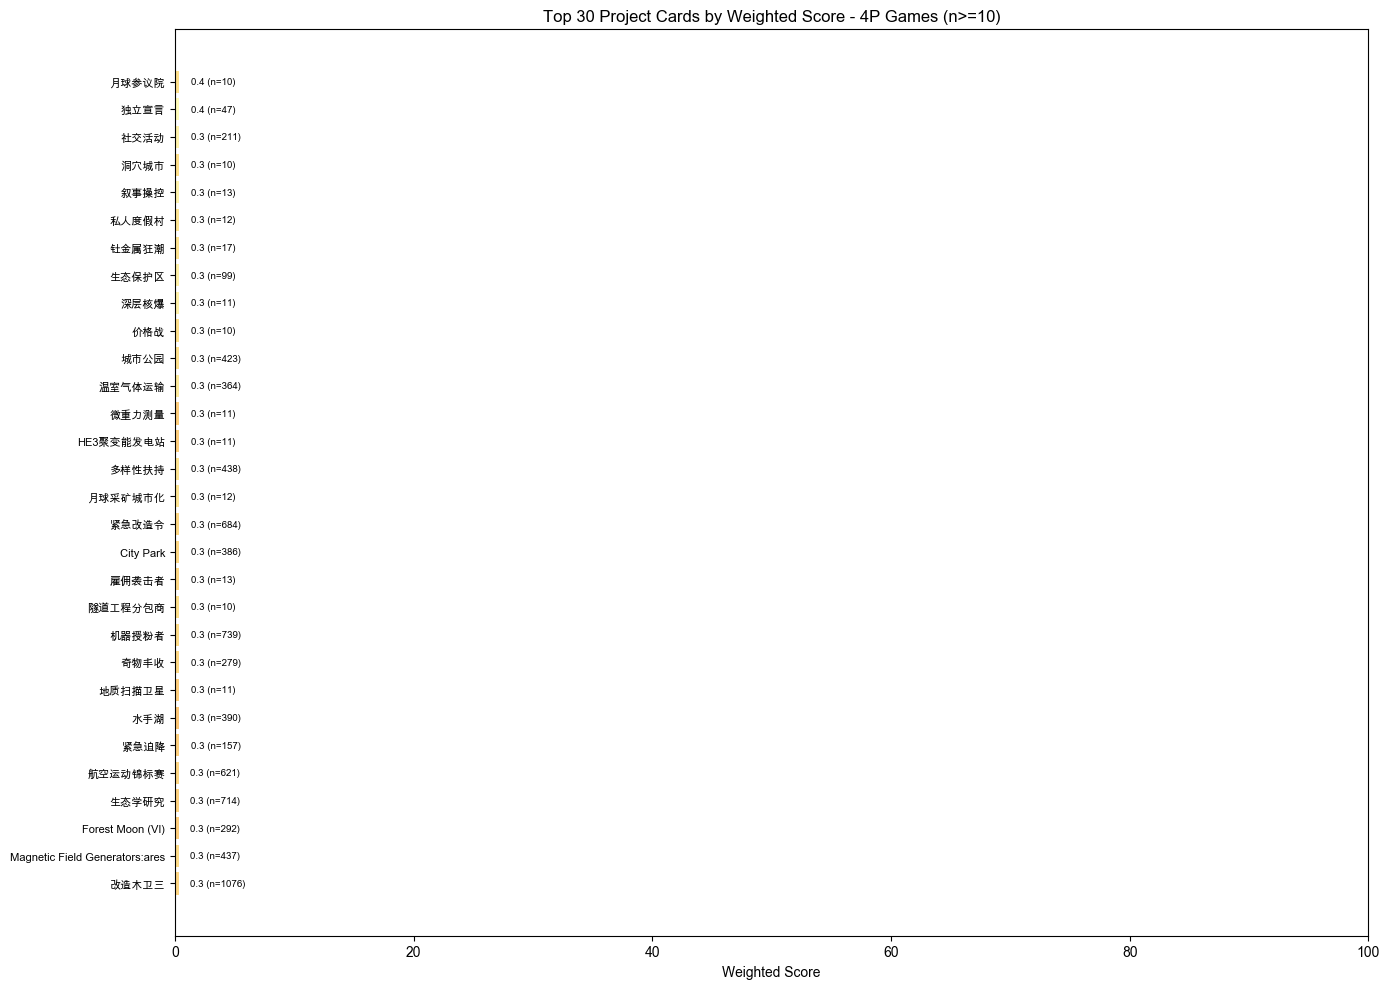

Saved: ./display/card_weighted_top30.png


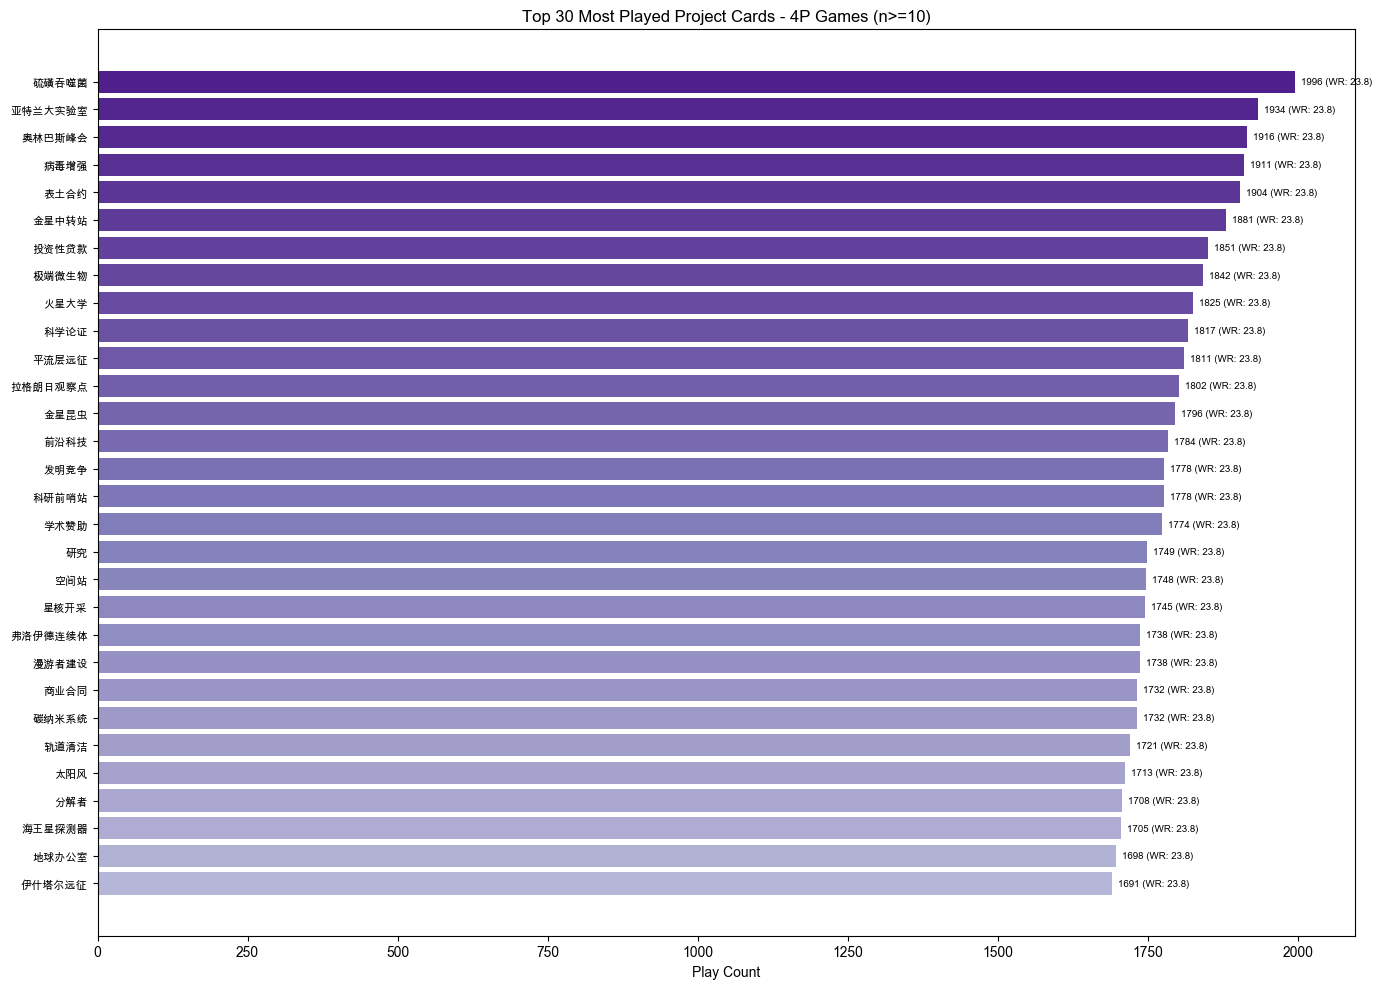

Saved: ./display/card_playcount_top30.png


In [24]:
# 6.5 Save Card Stats Data (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Save raw played cards data
    played_cards_df.to_csv(f'{DISPLAY_DIR}/played_cards_raw.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/played_cards_raw.csv ({len(played_cards_df)} rows)")

    # Re-analyze card stats using 4-player games only for accurate win rate
    # Filter to 4-player games and exclude preludes
    project_cards_df = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()
    card_stats_full = project_cards_df.groupby('card_name').agg(
        play_count=('game_id', 'count'),
        game_count=('game_id', 'nunique'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean'),
        avg_resources=('resource_count', 'mean')
    ).reset_index()
    card_stats_full['win_rate'] = (card_stats_full['wins'] / card_stats_full['play_count'] * 100).round(2)

    # Add cn_name column
    card_stats_full = add_cn_name_column(card_stats_full, 'card_name', CN_MAP)

    # Save FULL card stats data
    card_stats_full.to_csv(f'{DISPLAY_DIR}/card_stats_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_full.csv ({len(card_stats_full)} rows)")

    # Save FILTERED card stats data
    card_stats_filtered = card_stats_full[card_stats_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
    card_stats_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_filtered.csv ({len(card_stats_filtered)} rows)")

    # Visualization 1: Top 30 Cards by Weighted Score - FILTERED DATA
    fig, ax = plt.subplots(figsize=(14, 10))
    top30_winrate = card_stats_filtered.sort_values('weighted_avg_score', ascending=True).head(30)
    colors = plt.cm.RdYlGn(top30_winrate['win_rate'] / 100)
    bars = ax.barh(range(len(top30_winrate)), top30_winrate['weighted_avg_score'], color=colors)
    ax.set_yticks(range(len(top30_winrate)))
    ax.set_yticklabels(top30_winrate['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('平均顺位')
    ax.set_title(f'Top 30 Project Cards by Weighted Score - 4P Games (n>={MIN_SAMPLE_SIZE})')
    ax.set_xlim(1, 4)

    for bar, score, count in zip(bars, top30_winrate['weighted_avg_score'], top30_winrate['play_count']):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{score:.1f} (n={count})', va='center', fontsize=7)

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/card_weighted_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/card_weighted_top30.png")

    # Visualization 2: Top 30 Cards by Play Count - FILTERED DATA
    fig, ax = plt.subplots(figsize=(14, 10))
    top30_popular = card_stats_filtered.sort_values('play_count', ascending=False).head(30)
    colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(top30_popular)))[::-1]
    bars = ax.barh(range(len(top30_popular)), top30_popular['play_count'], color=colors)
    ax.set_yticks(range(len(top30_popular)))
    ax.set_yticklabels(top30_popular['cn_name_plot'], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Play Count')
    ax.set_title(f'Top 30 Most Played Project Cards - 4P Games (n>={MIN_SAMPLE_SIZE})')

    for bar, count, wr in zip(bars, top30_popular['play_count'], top30_popular['win_rate']):
        ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                f'{count} (WR: {ws:.1f})', va='center', fontsize=7)

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/card_playcount_top30.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/card_playcount_top30.png")
else:
    print("No card stats data available")

Saved: ./display/card_stats_by_players_full.csv (3409 rows)
Saved: ./display/card_stats_by_players_filtered.csv (2510 rows)
Saved: ./display/card_4p_weighted_full.csv (758 rows)
Saved: ./display/card_4p_weighted_filtered.csv (664 rows)


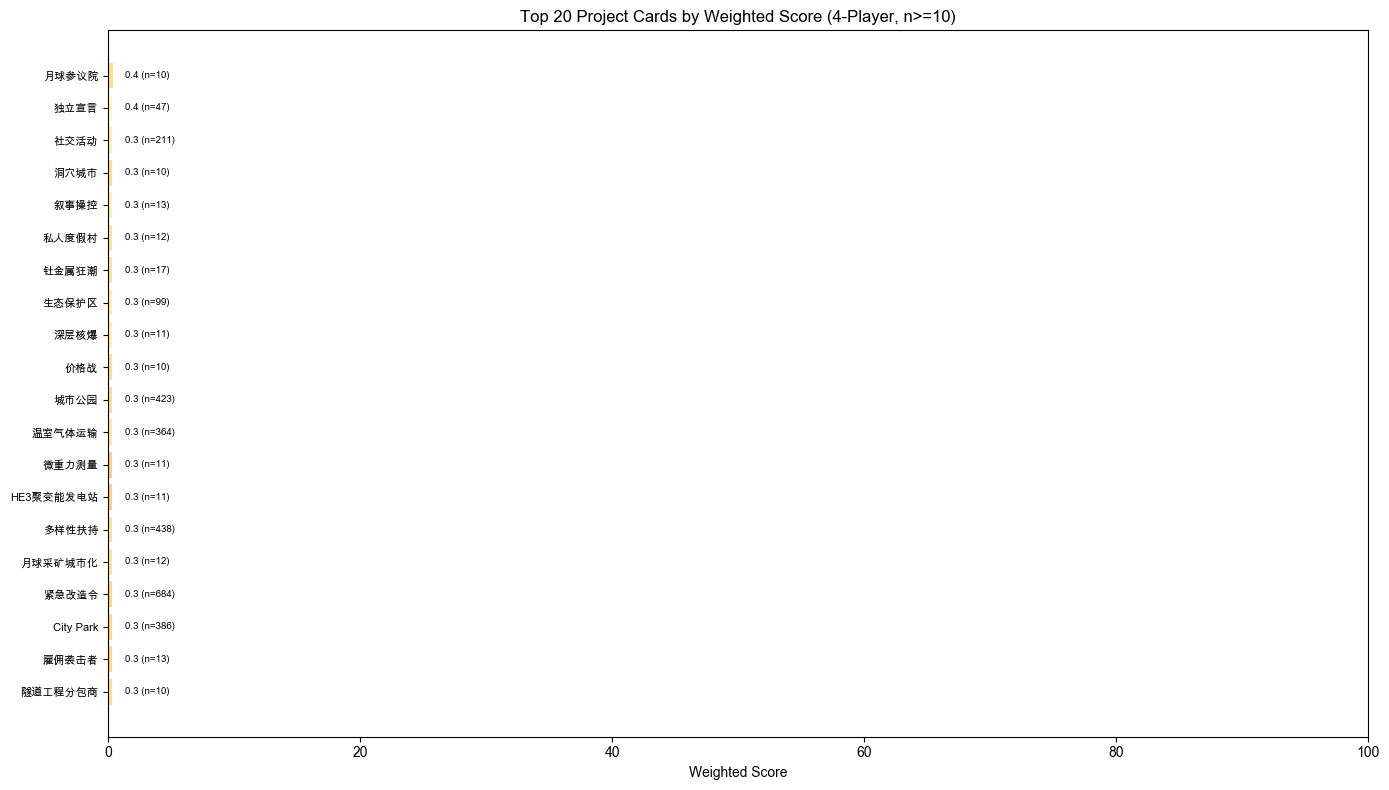

Saved: ./display/card_4p_weighted_top20.png


In [25]:
# 6.6 Save Card Stats by Player Count (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Re-analyze card stats by players without filter for full version
    project_cards_df = played_cards_df[(~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])].copy()
    card_by_players_full = project_cards_df.groupby(['card_name', 'players']).agg(
        play_count=('game_id', 'count'),
        wins=('position', lambda x: (x == 1).sum()),
        avg_position=('position', 'mean'),
        avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
    ).reset_index()
    card_by_players_full['win_rate'] = (card_by_players_full['wins'] / card_by_players_full['play_count'] * 100).round(2)

    # Add cn_name column
    card_by_players_full = add_cn_name_column(card_by_players_full, 'card_name', CN_MAP)

    # Save FULL card stats by players data
    card_by_players_full.to_csv(f'{DISPLAY_DIR}/card_stats_by_players_full.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_by_players_full.csv ({len(card_by_players_full)} rows)")

    # Save FILTERED card stats by players data
    card_by_players_filtered = card_by_players_full[card_by_players_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
    card_by_players_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_by_players_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_stats_by_players_filtered.csv ({len(card_by_players_filtered)} rows)")

    # 4-player card ranking - Full and Filtered
    card_4p_full = card_by_players_full[card_by_players_full['players'] == 4].sort_values('weighted_avg_score', ascending=True)
    card_4p_filtered = card_by_players_filtered[card_by_players_filtered['players'] == 4].sort_values('weighted_avg_score', ascending=True)

    card_4p_full.to_csv(f'{DISPLAY_DIR}/card_4p_weighted_full.csv', index=False)
    card_4p_filtered.to_csv(f'{DISPLAY_DIR}/card_4p_weighted_filtered.csv', index=False)
    print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_full.csv ({len(card_4p_full)} rows)")
    print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_filtered.csv ({len(card_4p_filtered)} rows)")

    # Visualization: Top 20 Cards in 4-Player Games - FILTERED DATA
    if len(card_4p_filtered) > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        top20_4p = card_4p_filtered.head(20)
        colors = plt.cm.RdYlGn(top20_4p['win_rate'] / 100)
        bars = ax.barh(range(len(top20_4p)), top20_4p['weighted_avg_score'], color=colors)
        ax.set_yticks(range(len(top20_4p)))
        ax.set_yticklabels(top20_4p['cn_name_plot'], fontsize=8)
        ax.invert_yaxis()
        ax.set_xlabel('平均顺位')
        ax.set_title(f'Top 20 Project Cards by Weighted Score (4-Player, n>={MIN_SAMPLE_SIZE})')
        ax.set_xlim(1, 4)

        for bar, score, count in zip(bars, top20_4p['weighted_avg_score'], top20_4p['play_count']):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} (n={count})', va='center', fontsize=7)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_4p_weighted_top20.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_4p_weighted_top20.png")
else:
    print("No card by players data available")

Saved: ./display/card_corporation_synergy_full.csv (62211 rows)
Saved: ./display/card_corporation_synergy_filtered.csv (28543 rows)


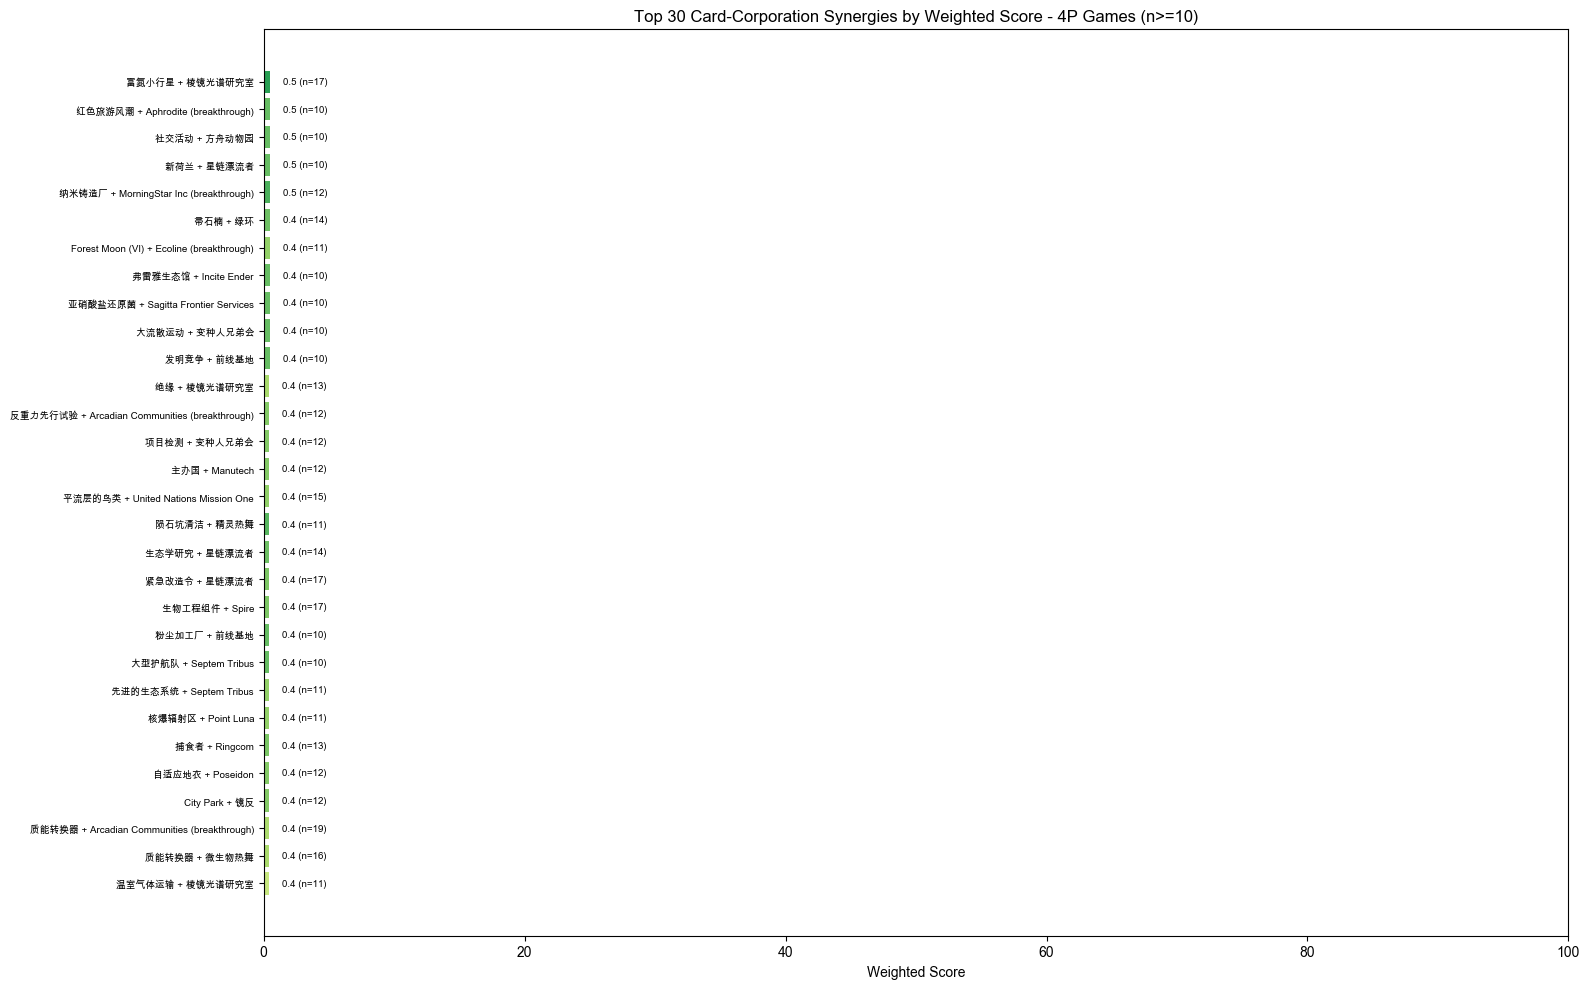

Saved: ./display/card_corporation_synergy_top30.png


In [26]:
# 6.7 Save Card-Corporation Synergy Data (Full + Filtered) and Visualize

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Re-analyze synergy using 4-player games only for accurate win rate
    project_cards_df = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()

    synergy_records = []
    for _, row in project_cards_df.iterrows():
        corps = split_corporations(row['corporation'])
        for corp in corps:
            synergy_records.append({
                'card_name': row['card_name'],
                'corporation': corp,
                'position': row['position'],
                'player_score': row['player_score'],
                'weighted_score': row['weighted_score']
            })

    if synergy_records:
        synergy_temp_df = pd.DataFrame(synergy_records)
        synergy_full = synergy_temp_df.groupby(['card_name', 'corporation']).agg(
            play_count=('position', 'count'),
            wins=('position', lambda x: (x == 1).sum()),
            avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
        ).reset_index()
        synergy_full['win_rate'] = (synergy_full['wins'] / synergy_full['play_count'] * 100).round(2)
        synergy_full = synergy_full.sort_values('weighted_avg_score', ascending=True)

        # Add cn_name columns for both card and corporation
        synergy_full['card_cn_name'] = synergy_full['card_name'].apply(lambda x: CN_MAP.get(x, x))
        synergy_full['corp_cn_name'] = synergy_full['corporation'].apply(lambda x: CN_MAP.get(x, x))

        # Save FULL synergy data
        synergy_full.to_csv(f'{DISPLAY_DIR}/card_corporation_synergy_full.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_full.csv ({len(synergy_full)} rows)")

        # Save FILTERED synergy data
        synergy_filtered = synergy_full[synergy_full['play_count'] >= MIN_SAMPLE_SIZE].copy()
        synergy_filtered.to_csv(f'{DISPLAY_DIR}/card_corporation_synergy_filtered.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_filtered.csv ({len(synergy_filtered)} rows)")

        # Visualization: Top 30 Card-Corporation Synergies - FILTERED DATA
        if len(synergy_filtered) > 0:
            fig, ax = plt.subplots(figsize=(16, 10))
            top30_synergy = synergy_filtered.head(30)
            labels = [f"{strip_emoji(row['card_cn_name'])} + {strip_emoji(row['corp_cn_name'])}" for _, row in top30_synergy.iterrows()]
            colors = plt.cm.RdYlGn(top30_synergy['win_rate'] / 100)
            bars = ax.barh(range(len(top30_synergy)), top30_synergy['weighted_avg_score'], color=colors)
            ax.set_yticks(range(len(top30_synergy)))
            ax.set_yticklabels(labels, fontsize=7)
            ax.invert_yaxis()
            ax.set_xlabel('平均顺位')
            ax.set_title(f'Top 30 Card-Corporation Synergies by Weighted Score - 4P Games (n>={MIN_SAMPLE_SIZE})')
            ax.set_xlim(1, 4)

            for bar, score, count in zip(bars, top30_synergy['weighted_avg_score'], top30_synergy['play_count']):
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                        f'{score:.1f} (n={count})', va='center', fontsize=7)

            plt.tight_layout()
            plt.savefig(f'{DISPLAY_DIR}/card_corporation_synergy_top30.png', dpi=150, bbox_inches='tight')
            plt.show()
            print(f"Saved: {DISPLAY_DIR}/card_corporation_synergy_top30.png")
else:
    print("No synergy data available")

In [27]:
# 6.8 Summary: List all exported files

print("=" * 70)
print("EXPORT SUMMARY - All files saved to ./display/")
print(f"Minimum sample size for filtered data: {MIN_SAMPLE_SIZE}")
print("=" * 70)

# List all files in display folder
display_files = sorted(os.listdir(DISPLAY_DIR))
csv_files = [f for f in display_files if f.endswith('.csv')]
png_files = [f for f in display_files if f.endswith('.png')]

# Separate full and filtered files
full_files = [f for f in csv_files if '_full' in f or '_raw' in f]
filtered_files = [f for f in csv_files if '_filtered' in f]

print("\nCSV Files - FULL (complete data, no filtering):")
print("-" * 50)
for f in full_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nCSV Files - FILTERED (n>={MIN_SAMPLE_SIZE}):")
print("-" * 50)
for f in filtered_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nTotal CSV files: {len(csv_files)} (Full: {len(full_files)}, Filtered: {len(filtered_files)})")

print("\nVisualization Files (PNG) - Based on FILTERED data:")
print("-" * 50)
for f in png_files:
    file_path = os.path.join(DISPLAY_DIR, f)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {f} ({size_kb:.1f} KB)")

print(f"\nTotal PNG files: {len(png_files)}")
print("=" * 70)
print("Export complete!")

EXPORT SUMMARY - All files saved to ./display/
Minimum sample size for filtered data: 10

CSV Files - FULL (complete data, no filtering):
--------------------------------------------------
  - card_4p_weighted_full.csv (86.2 KB)
  - card_4p_winrate_full.csv (75.0 KB)
  - card_corporation_synergy_full.csv (6209.0 KB)
  - card_stats_2p_full.csv (74.1 KB)
  - card_stats_4p_full.csv (71.9 KB)
  - card_stats_by_players_full.csv (358.3 KB)
  - card_stats_full.csv (90.6 KB)
  - corporation_4p_weighted_full.csv (17.2 KB)
  - corporation_4p_winrate_full.csv (17.3 KB)
  - corporation_combinations_full.csv (428.2 KB)
  - corporation_popularity_full.csv (12.8 KB)
  - corporation_usage_full.csv (65.2 KB)
  - played_cards_raw.csv (239524.3 KB)
  - prelude_stats_2p_full.csv (10.0 KB)
  - prelude_stats_4p_full.csv (9.9 KB)
  - prelude_stats_full.csv (13.4 KB)
  - prelude_usage_raw.csv (6808.2 KB)

CSV Files - FILTERED (n>=10):
--------------------------------------------------
  - card_4p_weighted_fil

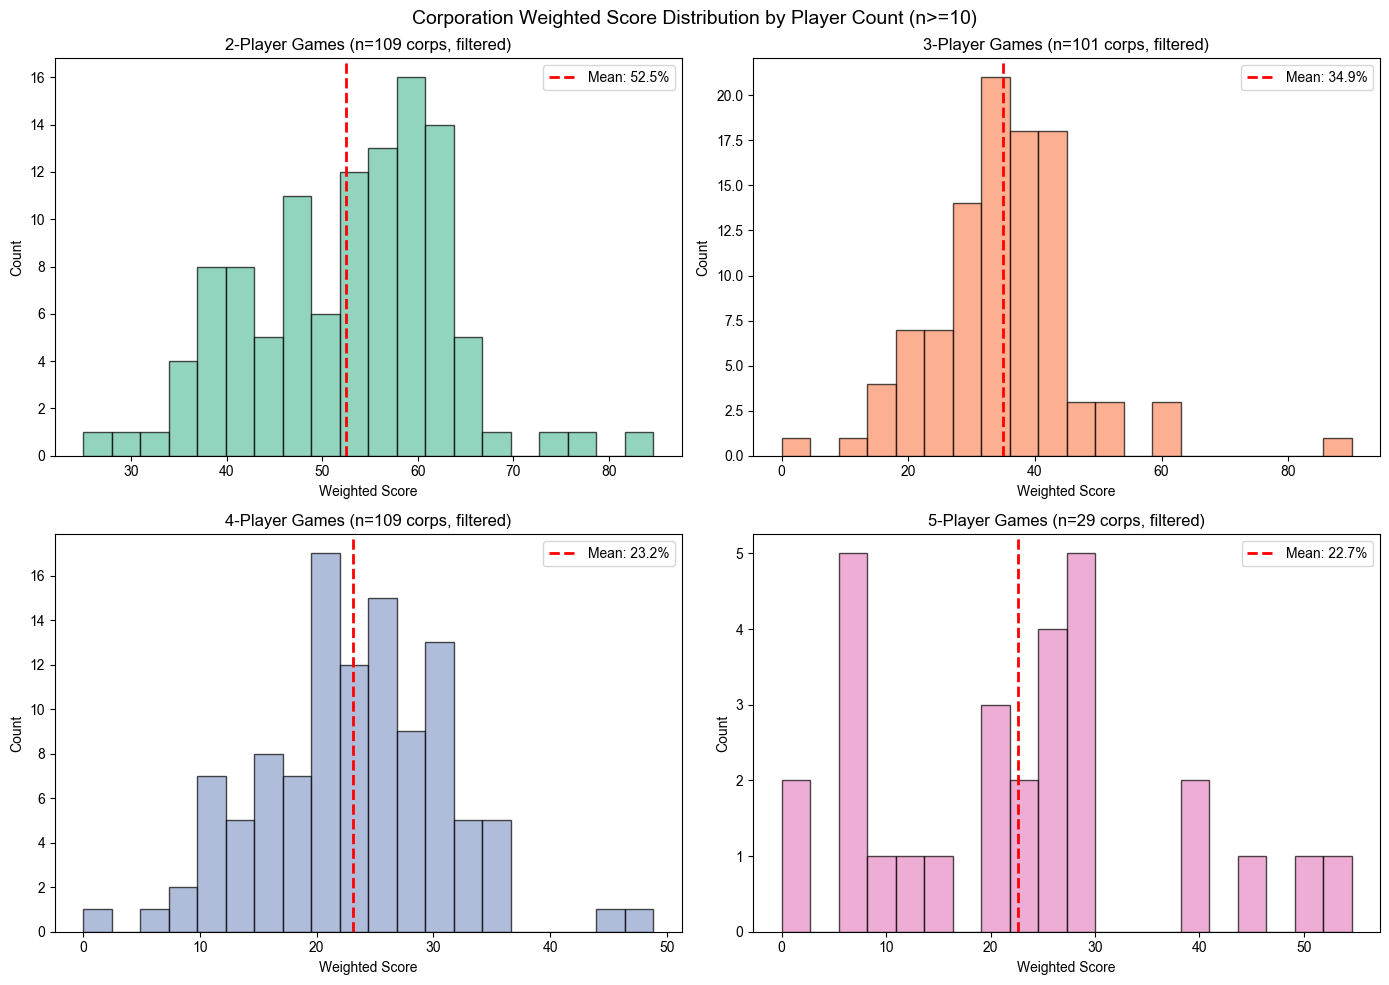

Saved: ./display/corporation_weighted_distribution.png


/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/4211124160.py:45: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/kt/jh5yr5kn50v_xx9qcjdrw3p40000gn/T/ipykernel_25648/4211124160.py:46: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  plt.savefig(f'{DISPLAY_DIR}/corporation_comparison_by_players.png', dpi=150, bbox_inches='tight')
/Users/oushuohuang/Documents/tfm-data/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)


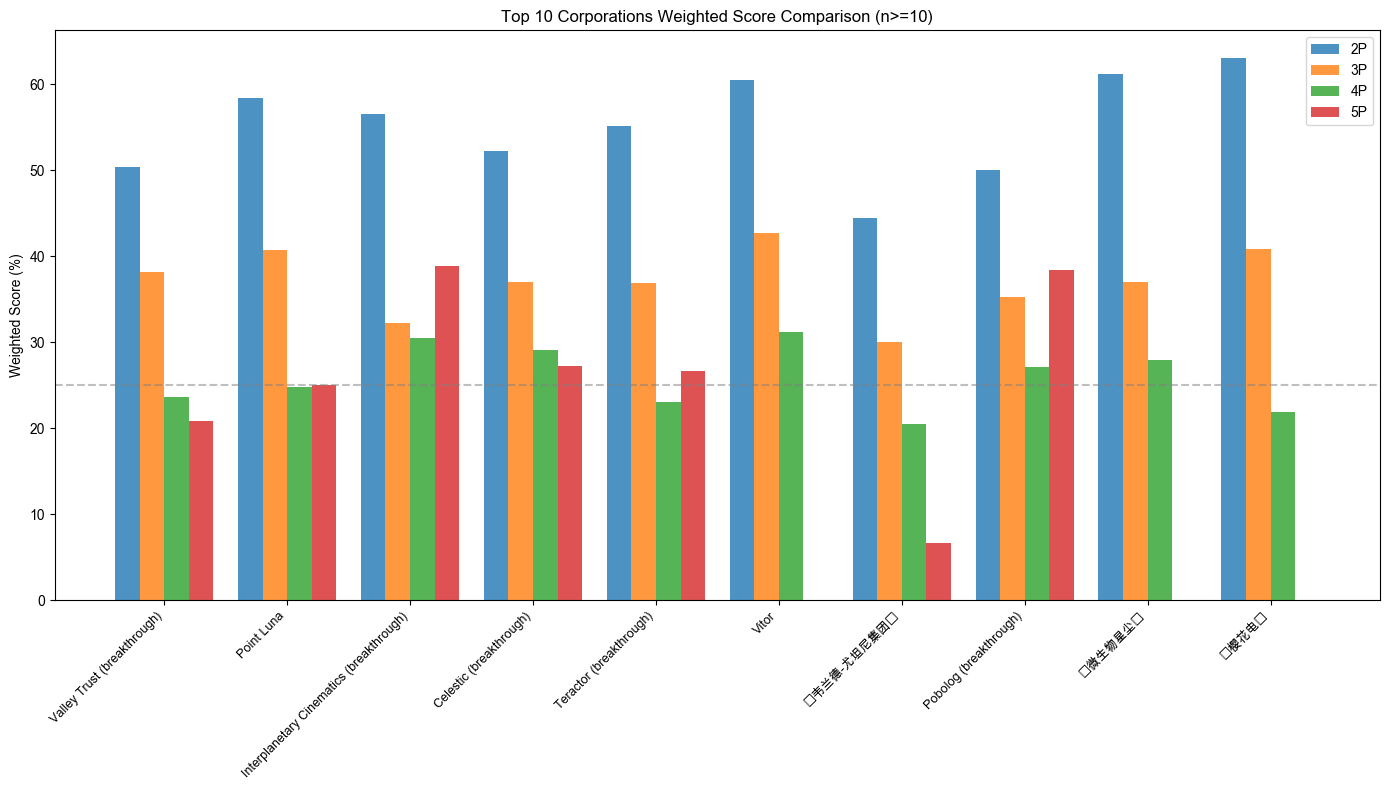

Saved: ./display/corporation_comparison_by_players.png


In [28]:
# 6.9 Additional Visualizations: Weighted Score Distribution and Comparison (FILTERED)

# 1. Corporation 平均顺位分布 by Player Count - Using FILTERED data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, players in enumerate([2, 3, 4, 5]):
    ax = axes[idx // 2, idx % 2]
    data = corp_usage_filtered[corp_usage_filtered['players'] == players]['weighted_avg_score']
    if len(data) > 0:
        ax.hist(data, bins=20, color=plt.cm.Set2(idx), edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        ax.set_xlim(1, 4)
        ax.set_xlabel('平均顺位')
        ax.set_ylabel('Count')
        ax.set_title(f'{players}-Player Games (n={len(data)} corps, filtered)')
        ax.legend()

plt.suptitle(f'Corporation 平均顺位分布 by Player Count (n>={MIN_SAMPLE_SIZE})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{DISPLAY_DIR}/corporation_weighted_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DISPLAY_DIR}/corporation_weighted_distribution.png")

# 2. Top 10 Corporations Comparison Across Player Counts - Using FILTERED data
corp_multi_player = corp_usage_filtered.groupby('corporation').filter(lambda x: len(x) >= 3)
if len(corp_multi_player) > 0:
    top_corps = corp_multi_player.groupby('corporation')['total_games'].sum().nlargest(10).index.tolist()

    fig, ax = plt.subplots(figsize=(14, 8))
    width = 0.2
    x = np.arange(len(top_corps))

    for i, players in enumerate([2, 3, 4, 5]):
        data = corp_usage_filtered[(corp_usage_filtered['players'] == players) & (corp_usage_filtered['corporation'].isin(top_corps))]
        win_rates = [data[data['corporation'] == c]['win_rate'].values[0] if c in data['corporation'].values else 0 for c in top_corps]
        ax.bar(x + i * width, win_rates, width, label=f'{players}P', alpha=0.8)

    ax.set_xticks(x + width * 1.5)
    top_corps_cn = [CN_MAP.get(c, c) for c in top_corps]
    ax.set_xticklabels(top_corps_cn, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Weighted Score (%)')
    ax.set_title(f'Top 10 Corporations Weighted Score Comparison (n>={MIN_SAMPLE_SIZE})')
    ax.legend()
    ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5, label='Expected 4P')

    plt.tight_layout()
    plt.savefig(f'{DISPLAY_DIR}/corporation_comparison_by_players.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {DISPLAY_DIR}/corporation_comparison_by_players.png")

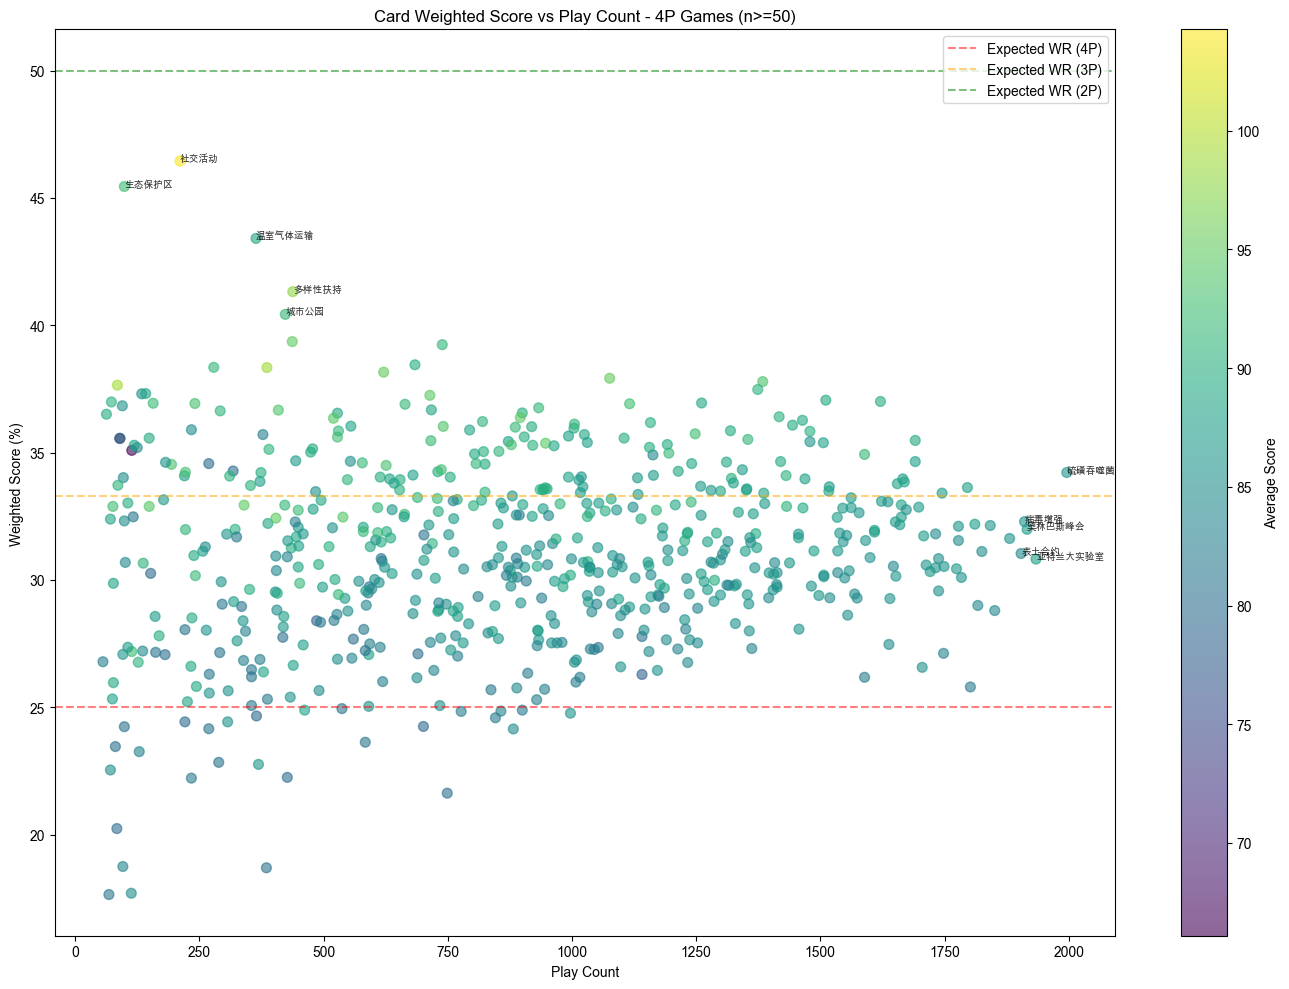

Saved: ./display/card_weighted_vs_playcount.png


In [29]:
# 6.10 Card Weighted Score vs Play Count Scatter Plot (FILTERED)

if 'card_stats_filtered' in dir() and len(card_stats_filtered) > 0:
    fig, ax = plt.subplots(figsize=(14, 10))

    # Use filtered data (already filtered by MIN_SAMPLE_SIZE)
    # Additionally filter to cards with at least 50 plays for clearer visualization
    plot_data = card_stats_filtered[card_stats_filtered['play_count'] >= 50].copy()

    if len(plot_data) > 0:
        scatter = ax.scatter(
            plot_data['play_count'],
            plot_data['win_rate'],
            c=plot_data['avg_score'],
            cmap='viridis',
            s=50,
            alpha=0.6
        )

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Average Score')

        # Add reference lines
        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Expected WR (4P)')
        ax.axhline(y=33.3, color='orange', linestyle='--', alpha=0.5, label='Expected WR (3P)')
        ax.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Expected WR (2P)')

        # Label some interesting points
        top_wr = plot_data.nlargest(5, 'win_rate')
        top_pop = plot_data.nlargest(5, 'play_count')

        for _, row in pd.concat([top_wr, top_pop]).drop_duplicates().iterrows():
            ax.annotate(
                row['cn_name_plot'][:15],
                (row['play_count'], row['win_rate']),
                fontsize=7,
                alpha=0.8
            )

        ax.set_xlabel('Play Count')
        ax.set_ylabel('Weighted Score (%)')
        ax.set_title(f'Card Weighted Score vs Play Count - 4P Games (n>=50)')
        ax.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_weighted_vs_playcount.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_weighted_vs_playcount.png")
    else:
        print("Not enough cards with 50+ plays for scatter plot")

## 7. Prelude and Card Stats by Player Count (2P vs 4P)

Saved: ./display/prelude_stats_2p_full.csv (108 rows)
Saved: ./display/prelude_stats_2p_filtered.csv (88 rows)


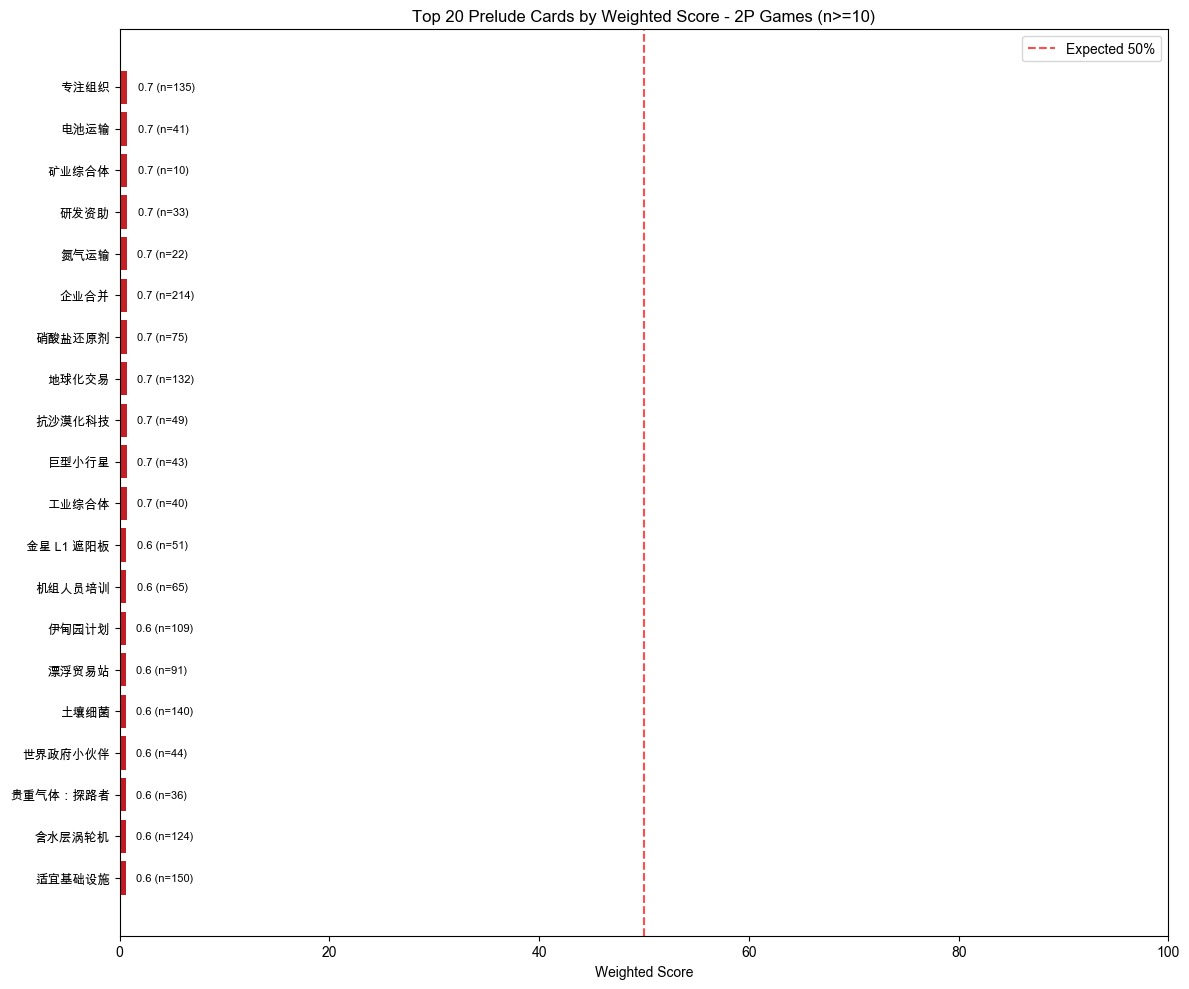

Saved: ./display/prelude_2p_weighted_top20.png
Saved: ./display/prelude_stats_4p_full.csv (109 rows)
Saved: ./display/prelude_stats_4p_filtered.csv (91 rows)


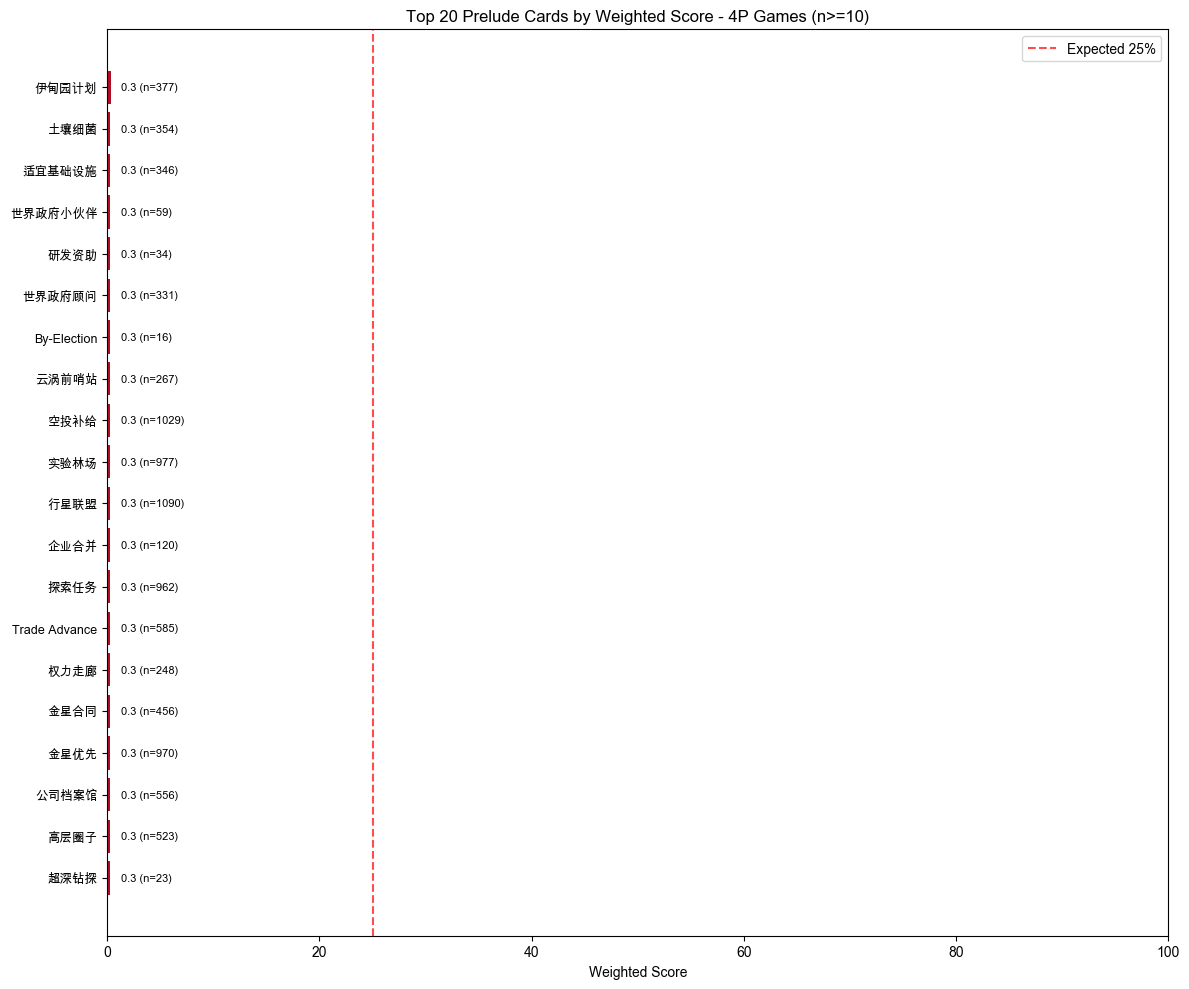

Saved: ./display/prelude_4p_weighted_top20.png


In [30]:
# 7.1 Prelude Stats by Player Count (2P vs 4P)

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Calculate prelude stats for 2P and 4P separately
    for players in [2, 4]:
        prelude_df_filtered = prelude_df[prelude_df['players'] == players].copy()

        if len(prelude_df_filtered) > 0:
            prelude_stats = prelude_df_filtered.groupby('prelude_name').agg(
                total_uses=('game_id', 'count'),
                wins=('position', lambda x: (x == 1).sum()),
                avg_position=('position', 'mean'),
                avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
            ).reset_index()
            prelude_stats['win_rate'] = (prelude_stats['wins'] / prelude_stats['total_uses'] * 100).round(2)
            prelude_stats = prelude_stats.sort_values('weighted_avg_score', ascending=True)

            # Add cn_name column
            prelude_stats = add_cn_name_column(prelude_stats, 'prelude_name', CN_MAP)

            # Save full and filtered versions
            prelude_stats.to_csv(f'{DISPLAY_DIR}/prelude_stats_{players}p_full.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/prelude_stats_{players}p_full.csv ({len(prelude_stats)} rows)")

            prelude_stats_filtered = prelude_stats[prelude_stats['total_uses'] >= MIN_SAMPLE_SIZE].copy()
            prelude_stats_filtered.to_csv(f'{DISPLAY_DIR}/prelude_stats_{players}p_filtered.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/prelude_stats_{players}p_filtered.csv ({len(prelude_stats_filtered)} rows)")

            # Visualization
            if len(prelude_stats_filtered) > 0:
                fig, ax = plt.subplots(figsize=(12, 10))
                top20 = prelude_stats_filtered.head(20)
                colors = plt.cm.RdYlGn(np.clip((4 - top20['weighted_avg_score']) / 3, 0, 1))
                bars = ax.barh(range(len(top20)), top20['weighted_avg_score'], color=colors)
                ax.set_yticks(range(len(top20)))
                ax.set_yticklabels(top20['cn_name_plot'], fontsize=9)
                ax.invert_yaxis()
                ax.set_xlabel('平均顺位')

                # Expected win rate line
                expected_wr = 50 if players == 2 else 25
                ax.axvline(x=expected_wr, color='red', linestyle='--', alpha=0.7, label=f'Expected {expected_wr}%')
                ax.legend()

                ax.set_title(f'Top 20 Prelude Cards by Weighted Score - {players}P Games (n>={MIN_SAMPLE_SIZE})')
                ax.set_xlim(1, 4)

                for bar, score, uses in zip(bars, top20['weighted_avg_score'], top20['total_uses']):
                    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                            f'{score:.1f} (n={uses})', va='center', fontsize=8)

                plt.tight_layout()
                plt.savefig(f'{DISPLAY_DIR}/prelude_{players}p_weighted_top20.png', dpi=150, bbox_inches='tight')
                plt.show()
                print(f"Saved: {DISPLAY_DIR}/prelude_{players}p_weighted_top20.png")
else:
    print("No prelude data available")

Saved: ./display/card_stats_2p_full.csv (763 rows)
Saved: ./display/card_stats_2p_filtered.csv (713 rows)


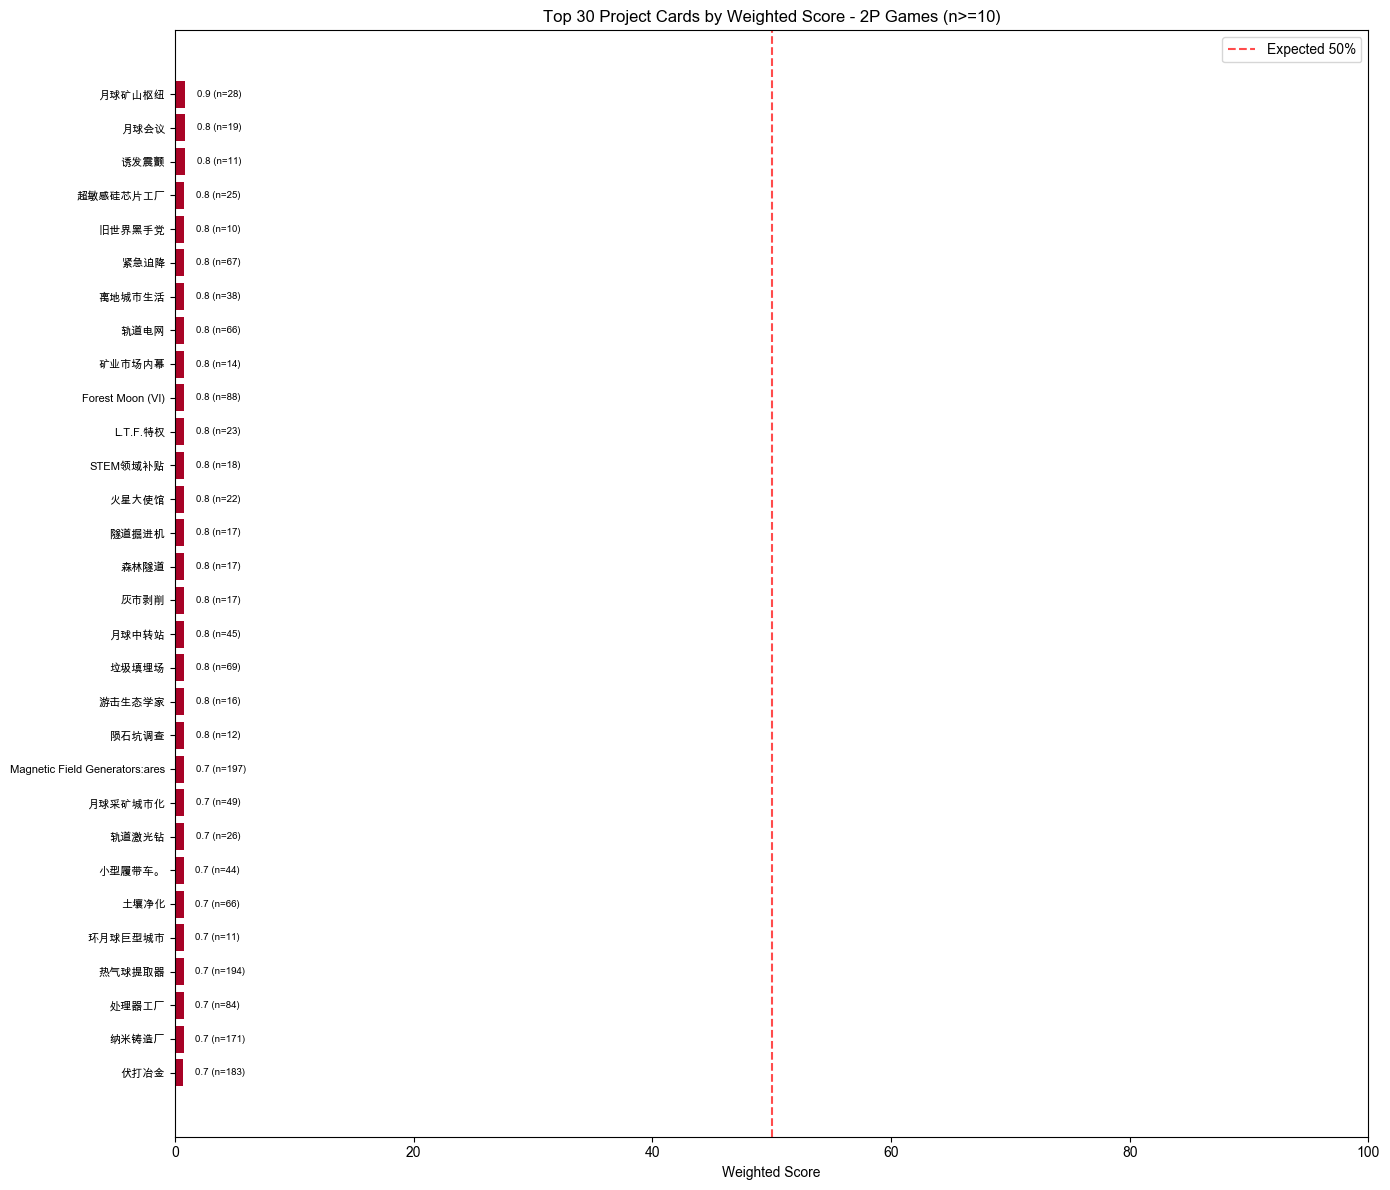

Saved: ./display/card_2p_weighted_top30.png
Saved: ./display/card_stats_4p_full.csv (758 rows)
Saved: ./display/card_stats_4p_filtered.csv (664 rows)


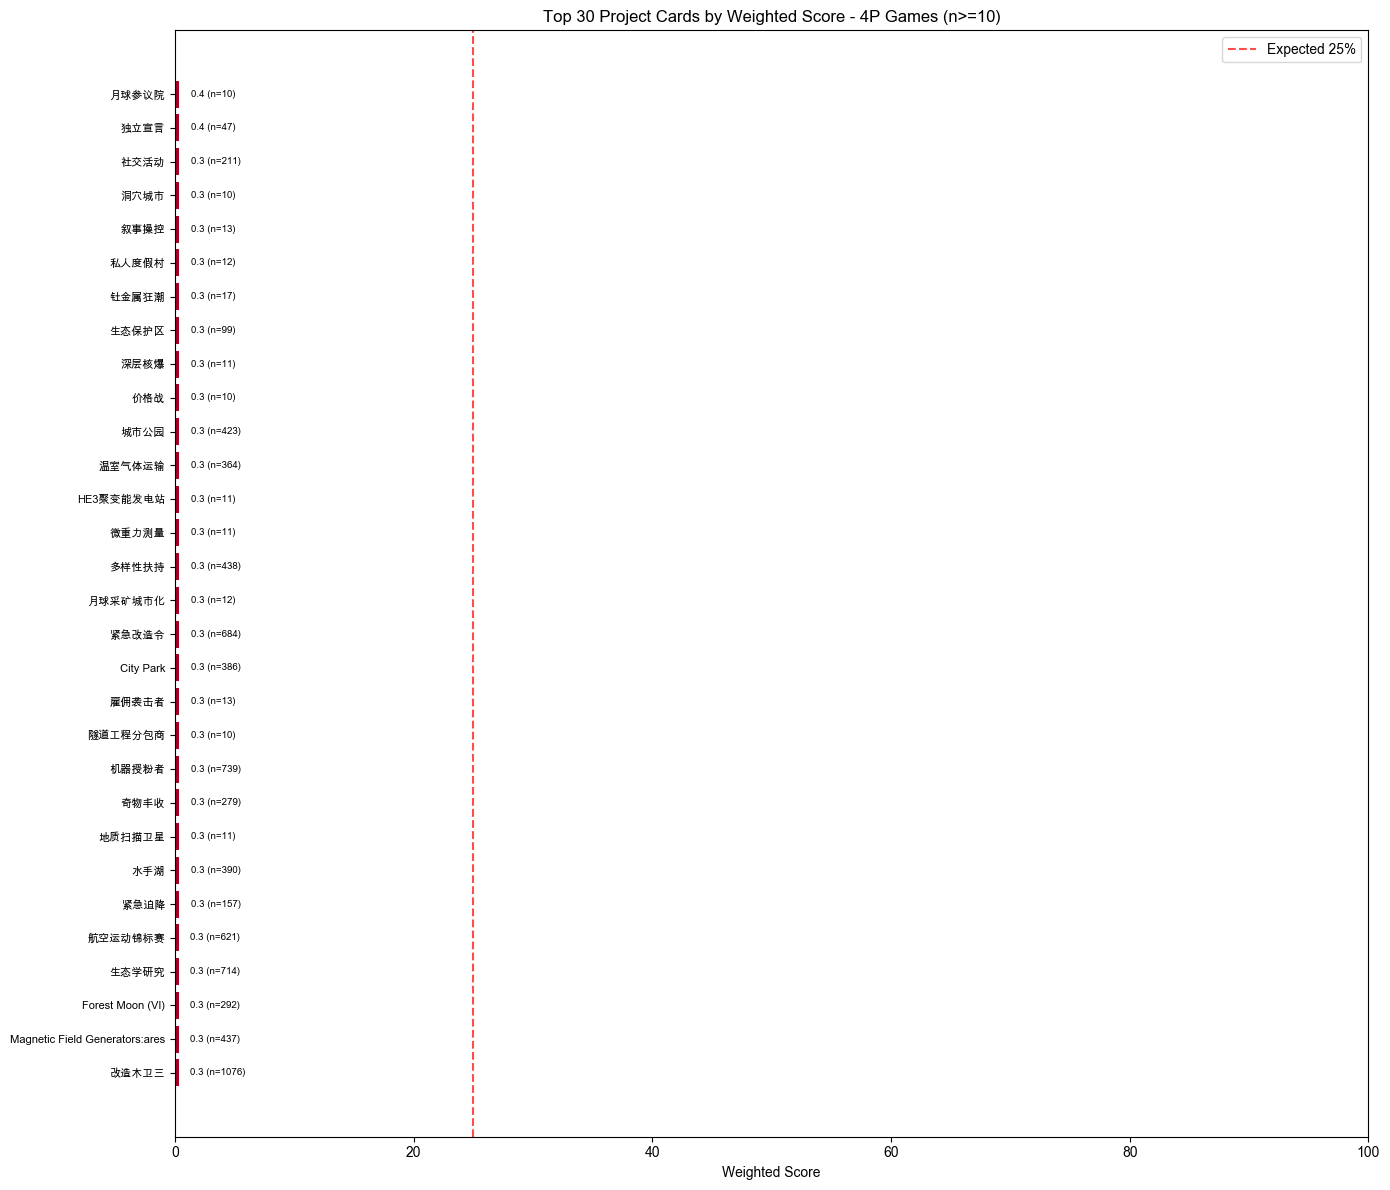

Saved: ./display/card_4p_weighted_top30.png


In [31]:
# 7.2 Card Stats by Player Count (2P vs 4P)

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Calculate card stats for 2P and 4P separately
    for players in [2, 4]:
        cards_df_filtered = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == players)].copy()

        if len(cards_df_filtered) > 0:
            card_stats = cards_df_filtered.groupby('card_name').agg(
                play_count=('game_id', 'count'),
                wins=('position', lambda x: (x == 1).sum()),
                avg_position=('position', 'mean'),
                avg_score=('player_score', 'mean'),
        weighted_avg_score=('weighted_score', 'mean')
            ).reset_index()
            card_stats['win_rate'] = (card_stats['wins'] / card_stats['play_count'] * 100).round(2)
            card_stats = card_stats.sort_values('weighted_avg_score', ascending=True)

            # Add cn_name column
            card_stats = add_cn_name_column(card_stats, 'card_name', CN_MAP)

            # Save full and filtered versions
            card_stats.to_csv(f'{DISPLAY_DIR}/card_stats_{players}p_full.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/card_stats_{players}p_full.csv ({len(card_stats)} rows)")

            card_stats_filtered = card_stats[card_stats['play_count'] >= MIN_SAMPLE_SIZE].copy()
            card_stats_filtered.to_csv(f'{DISPLAY_DIR}/card_stats_{players}p_filtered.csv', index=False)
            print(f"Saved: {DISPLAY_DIR}/card_stats_{players}p_filtered.csv ({len(card_stats_filtered)} rows)")

            # Visualization - Top 30 by Weighted Score
            if len(card_stats_filtered) > 0:
                fig, ax = plt.subplots(figsize=(14, 12))
                top30 = card_stats_filtered.head(30)
                colors = plt.cm.RdYlGn(np.clip((4 - top30['weighted_avg_score']) / 3, 0, 1))
                bars = ax.barh(range(len(top30)), top30['weighted_avg_score'], color=colors)
                ax.set_yticks(range(len(top30)))
                ax.set_yticklabels(top30['cn_name_plot'], fontsize=8)
                ax.invert_yaxis()
                ax.set_xlabel('平均顺位')

                # Expected win rate line
                expected_wr = 50 if players == 2 else 25
                ax.axvline(x=expected_wr, color='red', linestyle='--', alpha=0.7, label=f'Expected {expected_wr}%')
                ax.legend()

                ax.set_title(f'Top 30 Project Cards by Weighted Score - {players}P Games (n>={MIN_SAMPLE_SIZE})')
                ax.set_xlim(1, 4)

                for bar, score, count in zip(bars, top30['weighted_avg_score'], top30['play_count']):
                    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                            f'{score:.1f} (n={count})', va='center', fontsize=7)

                plt.tight_layout()
                plt.savefig(f'{DISPLAY_DIR}/card_{players}p_weighted_top30.png', dpi=150, bbox_inches='tight')
                plt.show()
                print(f"Saved: {DISPLAY_DIR}/card_{players}p_weighted_top30.png")
else:
    print("No card data available")

Saved: ./display/card_2p_vs_4p_comparison.csv (657 rows)


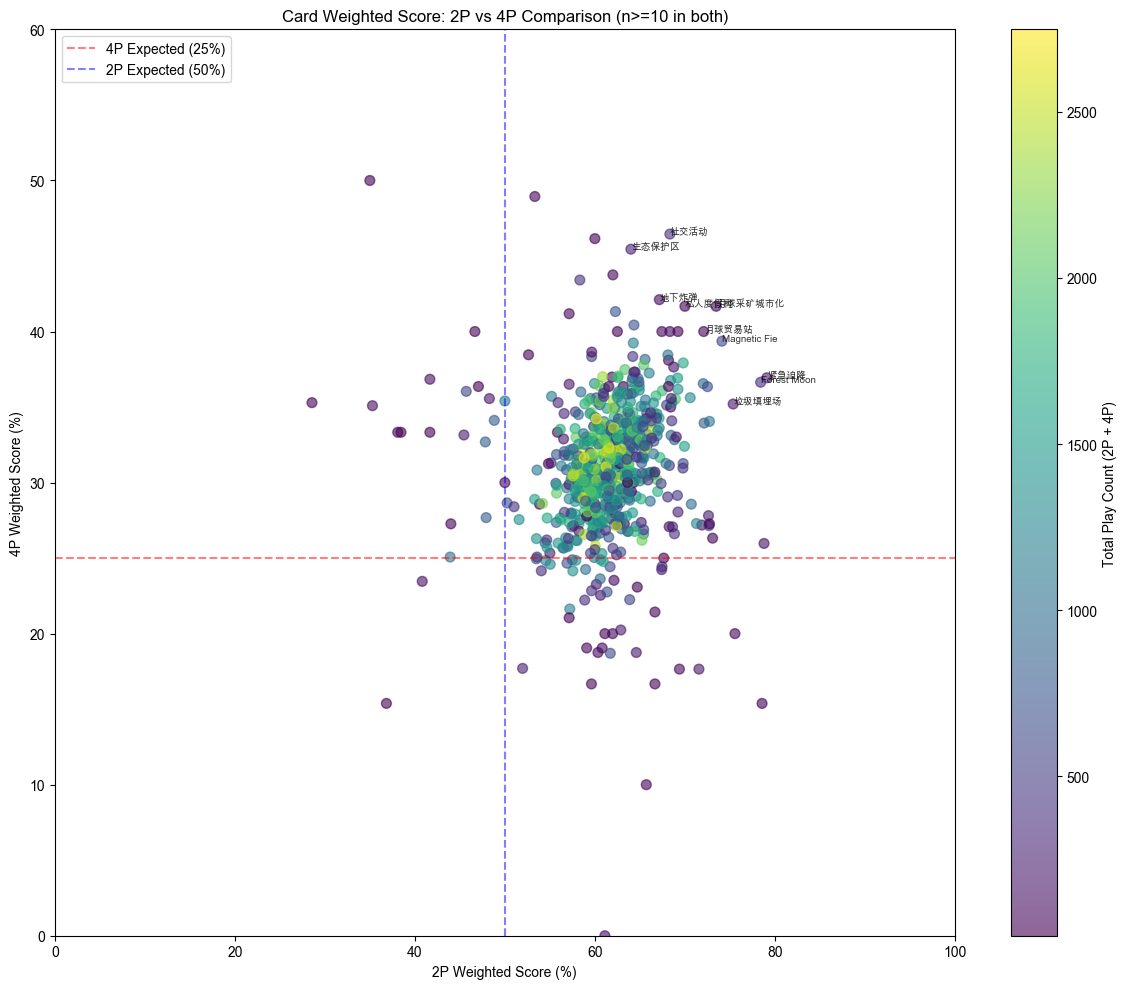

Saved: ./display/card_2p_vs_4p_scatter.png


In [32]:
# 7.3 Comparison: 2P vs 4P Weighted Score for Top Cards

if 'played_cards_df' in dir() and len(played_cards_df) > 0:
    # Get card stats for both 2P and 4P
    cards_2p = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 2)].copy()
    cards_4p = played_cards_df[((~played_cards_df['is_prelude']) & (~played_cards_df['is_corporation']) & (~played_cards_df['is_ceo'])) & (played_cards_df['players'] == 4)].copy()

    if len(cards_2p) > 0 and len(cards_4p) > 0:
        # Calculate stats
        stats_2p = cards_2p.groupby('card_name').agg(
            play_count_2p=('game_id', 'count'),
            wins_2p=('position', lambda x: (x == 1).sum())
        ).reset_index()
        stats_2p['weighted_2p'] = (stats_2p['wins_2p'] / stats_2p['play_count_2p'] * 100).round(2)

        stats_4p = cards_4p.groupby('card_name').agg(
            play_count_4p=('game_id', 'count'),
            wins_4p=('position', lambda x: (x == 1).sum())
        ).reset_index()
        stats_4p['weighted_4p'] = (stats_4p['wins_4p'] / stats_4p['play_count_4p'] * 100).round(2)

        # Merge
        comparison = stats_2p.merge(stats_4p, on='card_name', how='inner')
        comparison = comparison[(comparison['play_count_2p'] >= MIN_SAMPLE_SIZE) &
                                (comparison['play_count_4p'] >= MIN_SAMPLE_SIZE)]

        # Add cn_name
        comparison = add_cn_name_column(comparison, 'card_name', CN_MAP)

        # Calculate normalized win rate (relative to expected)
        comparison['wr_diff_2p'] = comparison['weighted_2p'] - 50  # 2P expected is 50%
        comparison['wr_diff_4p'] = comparison['weighted_4p'] - 25  # 4P expected is 25%
        comparison['total_diff'] = comparison['wr_diff_2p'] + comparison['wr_diff_4p']

        # Save comparison
        comparison.to_csv(f'{DISPLAY_DIR}/card_2p_vs_4p_comparison.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/card_2p_vs_4p_comparison.csv ({len(comparison)} rows)")

        # Visualization: Scatter plot comparing 2P vs 4P win rates
        fig, ax = plt.subplots(figsize=(12, 10))

        scatter = ax.scatter(
            comparison['weighted_2p'],
            comparison['weighted_4p'],
            c=comparison['play_count_2p'] + comparison['play_count_4p'],
            cmap='viridis',
            s=50,
            alpha=0.6
        )

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Total Play Count (2P + 4P)')

        # Add reference lines
        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='4P Expected (25%)')
        ax.axvline(x=50, color='blue', linestyle='--', alpha=0.5, label='2P Expected (50%)')

        # Label top performers
        top_overall = comparison.nlargest(10, 'total_diff')
        for _, row in top_overall.iterrows():
            ax.annotate(
                row['cn_name_plot'][:12],
                (row['weighted_2p'], row['weighted_4p']),
                fontsize=7,
                alpha=0.8
            )

        ax.set_xlabel('2P Weighted Score (%)')
        ax.set_ylabel('4P Weighted Score (%)')
        ax.set_title(f'Card Weighted Score: 2P vs 4P Comparison (n>={MIN_SAMPLE_SIZE} in both)')
        ax.legend(loc='upper left')
        ax.set_xlim(1, 4)
        ax.set_ylim(0, 60)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/card_2p_vs_4p_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/card_2p_vs_4p_scatter.png")

Saved: ./display/prelude_2p_vs_4p_comparison.csv (84 rows)


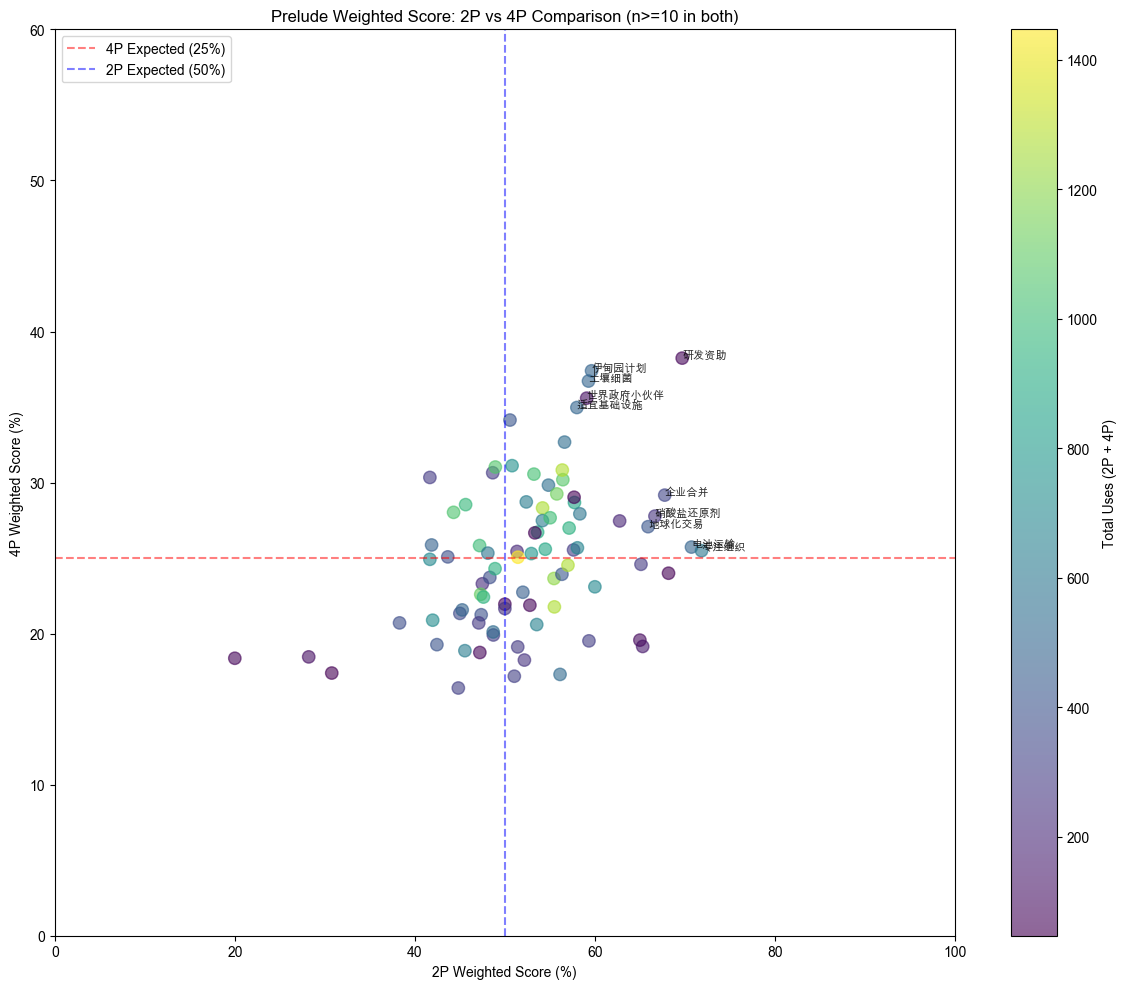

Saved: ./display/prelude_2p_vs_4p_scatter.png


In [33]:
# 7.4 Comparison: 2P vs 4P Weighted Score for Preludes

if 'prelude_df' in dir() and len(prelude_df) > 0:
    # Get prelude stats for both 2P and 4P
    prelude_2p = prelude_df[prelude_df['players'] == 2].copy()
    prelude_4p = prelude_df[prelude_df['players'] == 4].copy()

    if len(prelude_2p) > 0 and len(prelude_4p) > 0:
        # Calculate stats
        stats_2p = prelude_2p.groupby('prelude_name').agg(
            uses_2p=('game_id', 'count'),
            wins_2p=('position', lambda x: (x == 1).sum())
        ).reset_index()
        stats_2p['weighted_2p'] = (stats_2p['wins_2p'] / stats_2p['uses_2p'] * 100).round(2)

        stats_4p = prelude_4p.groupby('prelude_name').agg(
            uses_4p=('game_id', 'count'),
            wins_4p=('position', lambda x: (x == 1).sum())
        ).reset_index()
        stats_4p['weighted_4p'] = (stats_4p['wins_4p'] / stats_4p['uses_4p'] * 100).round(2)

        # Merge
        comparison = stats_2p.merge(stats_4p, on='prelude_name', how='inner')
        comparison = comparison[(comparison['uses_2p'] >= MIN_SAMPLE_SIZE) &
                                (comparison['uses_4p'] >= MIN_SAMPLE_SIZE)]

        # Add cn_name
        comparison = add_cn_name_column(comparison, 'prelude_name', CN_MAP)

        # Calculate normalized win rate
        comparison['wr_diff_2p'] = comparison['weighted_2p'] - 50
        comparison['wr_diff_4p'] = comparison['weighted_4p'] - 25
        comparison['total_diff'] = comparison['wr_diff_2p'] + comparison['wr_diff_4p']

        # Save comparison
        comparison.to_csv(f'{DISPLAY_DIR}/prelude_2p_vs_4p_comparison.csv', index=False)
        print(f"Saved: {DISPLAY_DIR}/prelude_2p_vs_4p_comparison.csv ({len(comparison)} rows)")

        # Visualization: Scatter plot
        fig, ax = plt.subplots(figsize=(12, 10))

        scatter = ax.scatter(
            comparison['weighted_2p'],
            comparison['weighted_4p'],
            c=comparison['uses_2p'] + comparison['uses_4p'],
            cmap='viridis',
            s=80,
            alpha=0.6
        )

        cbar = plt.colorbar(scatter)
        cbar.set_label('Total Uses (2P + 4P)')

        ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='4P Expected (25%)')
        ax.axvline(x=50, color='blue', linestyle='--', alpha=0.5, label='2P Expected (50%)')

        # Label top performers
        top_overall = comparison.nlargest(10, 'total_diff')
        for _, row in top_overall.iterrows():
            ax.annotate(
                row['cn_name_plot'][:12],
                (row['weighted_2p'], row['weighted_4p']),
                fontsize=8,
                alpha=0.8
            )

        ax.set_xlabel('2P Weighted Score (%)')
        ax.set_ylabel('4P Weighted Score (%)')
        ax.set_title(f'Prelude Weighted Score: 2P vs 4P Comparison (n>={MIN_SAMPLE_SIZE} in both)')
        ax.legend(loc='upper left')
        ax.set_xlim(1, 4)
        ax.set_ylim(0, 60)

        plt.tight_layout()
        plt.savefig(f'{DISPLAY_DIR}/prelude_2p_vs_4p_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {DISPLAY_DIR}/prelude_2p_vs_4p_scatter.png")